# Generative Teaching Networks (GTN)

Start by running the following two cells. The first cell imports packages that you'll use 

In [2]:
import sys
import os
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.datasets.cifar import CIFAR10
from torch.optim import Adam
from torch import nn as nn
import torchvision
import torchvision.transforms as transformers
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

define hyperparameters with respect of [paper](https://arxiv.org/abs/1912.07768)

In [3]:
lr = .002
init_lr = .02
initial_momentum = .5
beta1 = .9
beta2 = .9
momentum_eps = 1e-5
latent_variable = 128
inner_loop_batch_size = 128
outer_loop_batch_size = 256

define other hyperparameters

In [4]:
noise_size = 64
number_classes = 10
device = "cuda"
inner_loop_epoch = 5
outer_loop_epoch = 5
test_eval_step = 1

now lets define a function to display output of teacher and learner

In [60]:
def output_image_display(data, target, num_class_select=1):
    data = data.cpu().detach()
    target = torch.argmax(target, 1).cpu().detach().numpy()
    classes_list = list(np.unique(target))
    image_list = []
    for cls in classes_list:
        class_index = np.where(target == cls)
        class_len = class_index[0].__len__() - 1
        target_indexes = np.random.randint(0, class_len, [num_class_select])
        select_indexes = class_index[0][target_indexes]
        for i in select_indexes:
            image_list.append(data[i])

    image_grid = make_grid(image_list, padding=4, pad_value=.8, nrow=classes_list.__len__())
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

its time to set train, dev and test data

In [7]:
transformer_train = transformers.Compose([transformers.ToTensor(),
                                    transformers.RandomCrop(32),
                                    transformers.RandomHorizontalFlip()])
transformer_test = transformers.Compose([transformers.ToTensor()])
train_set = CIFAR10(".", train=True, transform=transformer_train, download=True)
dev_split_len = int(train_set.__len__() * .12)
train_set, dev_set = torch.utils.data.random_split(train_set, [train_set.__len__() - dev_split_len, dev_split_len])
test_set = CIFAR10(".", train=False, transform=transformer_test, download=True)

train = DataLoader(train_set, outer_loop_batch_size, drop_last=True, shuffle=True)
dev = DataLoader(dev_set, outer_loop_batch_size, drop_last=True, shuffle=True)
test = DataLoader(test_set, outer_loop_batch_size, drop_last=True, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


# **its time to dive in  to models**

Teacher is generator and suppose to generate new samples.

Learner should assess output of generator

In [52]:
class Teacher(nn.Module):
    def __init__(self, noise_size, num_class, image_shape=[32, 32]):
        super(Teacher, self).__init__()
        self.width = image_shape[0]
        self.height = image_shape[1]
        self.filter = 128

        first_fc_filter = 1024
        second_fc_filter = self.filter * self.width * self.height

        self.fc1 = nn.Linear(noise_size + num_class, first_fc_filter)
        nn.init.kaiming_normal_(self.fc1.weight, 0.1)
        self.bn1 = nn.BatchNorm1d(first_fc_filter, momentum=.1)

        self.fc2 = nn.Linear(first_fc_filter, second_fc_filter)  # 64, 256
        nn.init.kaiming_normal_(self.fc2.weight, 0.1)
        self.bn2 = nn.BatchNorm2d(self.filter, momentum=.1)

        self.conv1 = nn.Conv2d(self.filter, 64, 3, 1, padding=3//2)
        self.bn3 = nn.BatchNorm2d(64, momentum=.1)

        self.conv2 = nn.Conv2d(64, 3, 3, 1, padding=3//2)
        self.bn4 = nn.BatchNorm2d(3, momentum=.1)

        self.activation = nn.Tanh()

    def forward(self, x, target, training=True):
        x = torch.cat([x, target], dim=1)
        # block 1
        x = self.fc1(x)
        x = nn.functional.leaky_relu(x)
        x = self.bn1(x)
        # block 2
        x = self.fc2(x)
        x = nn.functional.leaky_relu(x)
        x = x.view(-1, self.filter, self.width, self.height)
        x = self.bn2(x)
        # block 3
        x = self.conv1(x)
        x = self.bn3(x)
        x = nn.functional.leaky_relu(x)
        # block 4
        x = self.conv2(x)
        x = self.bn4(x)
        if training:
            x = self.activation(x)
            x = nn.functional.normalize(x)
        else:
            x = self.activation(x)
        return x, target


class Learner(nn.Module):
    def __init__(self, num_conv_first=None, num_conv_other=None, number_classes=10, img_size=32, device="cuda"):
        super(Learner, self).__init__()
        if num_conv_first is None:
            conv1_filters = np.random.randint(32, 128)
        else:
            conv1_filters = num_conv_first

        if num_conv_other is None:
            conv2_filters = np.random.randint(64, 256)
        else:
            conv2_filters = num_conv_other

        self.conv1 = nn.Conv2d(3, conv1_filters, 3, 1) # 32, 128
        self.bn1 = nn.BatchNorm2d(conv1_filters, momentum=.1)

        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, 3, 2) # 64, 256
        self.bn2 = nn.BatchNorm2d(conv2_filters, momentum=.1)

        self.conv3 = nn.Conv2d(conv2_filters, conv2_filters, 3, 1)  # 64, 256
        self.bn3 = nn.BatchNorm2d(conv2_filters, momentum=.1)

        self.conv4 = nn.Conv2d(conv2_filters, conv2_filters, 3, 2)  # 64, 256
        self.bn4 = nn.BatchNorm2d(conv2_filters, momentum=.1)

        self.conv5 = nn.Conv2d(conv2_filters, conv2_filters, 3, 1)  # 64, 256
        self.bn5 = nn.BatchNorm2d(conv2_filters, momentum=.1)

        self.fc = nn.Linear(conv2_filters, number_classes)
        self.bn6 = nn.BatchNorm1d(number_classes, momentum=.1)
        self.activation = nn.LeakyReLU(.1)

    def forward(self, x):
        # block 1
        x = self.conv1(x)
        x = self.activation(x)
        x = self.bn1(x)
        # block 2
        x = self.conv2(x)
        x = self.activation(x)
        x = self.bn2(x)
        # block 3
        x = self.conv3(x)
        x = self.activation(x)
        x = self.bn3(x)
        # block 4
        x = self.conv4(x)
        x = self.activation(x)
        x = self.bn4(x)
        # block 5
        x = self.conv5(x)
        x = self.activation(x)
        x = self.bn5(x)
        # block 3
        x = nn.functional.avg_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.bn6(x)
        return x

initial model parameters and **curriculum**

In [53]:
gen = Teacher(noise_size=noise_size, num_class=number_classes).to(device)
params_to_train = list(gen.parameters())
use_curriculum = True
if use_curriculum:
    curriculum = nn.Parameter(torch.randn(inner_loop_epoch, outer_loop_batch_size, noise_size).to(device), requires_grad=True)
    params_to_train += [curriculum]
opt = Adam(params=params_to_train, lr=lr, betas=[beta1, beta2], eps=momentum_eps)
criterion = nn.CrossEntropyLoss()

label = torch.tensor([x % number_classes for x in range(outer_loop_batch_size)]).to(device)

# Training

in this notebook.i implement two type of training. you should run one of this 

first in with out [higher](https://github.com/facebookresearch/higher) secon with [higher](https://github.com/facebookresearch/higher)

**Higher** allows you to "unroll" inner gradient updates. Unrolling inner updates means that instead of computing updates in a loop where previous updates are overwritten (i.e. one step of traditional SGD), each update is stored, which makes it easier to compute and apply gradients to the generator through multiple updates of the student.

  0%|          | 0/172 [00:00<?, ?it/s]

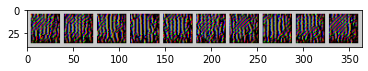

EPOCH: 0 Inner loop losses: 0.868, Train accuracy: 0.0859375, Validation accuracy: 0.09765625
EPOCH 0 Final test accuracy: 0.10068359375


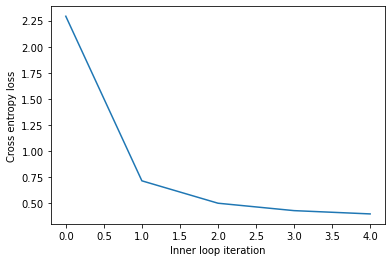

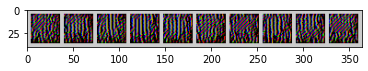

EPOCH: 1 Inner loop losses: 0.981, Train accuracy: 0.12109375, Validation accuracy: 0.08984375
EPOCH 1 Final test accuracy: 0.088671875


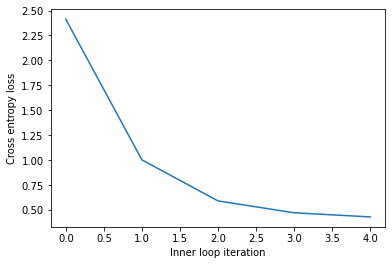

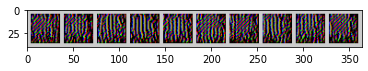

EPOCH: 2 Inner loop losses: 1.012, Train accuracy: 0.07421875, Validation accuracy: 0.109375
EPOCH 2 Final test accuracy: 0.0984375


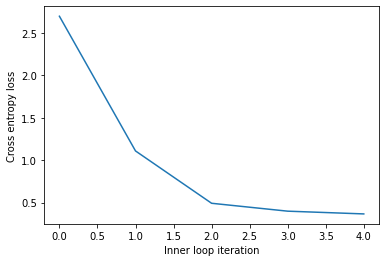

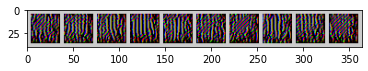

EPOCH: 3 Inner loop losses: 0.846, Train accuracy: 0.06640625, Validation accuracy: 0.125
EPOCH 3 Final test accuracy: 0.0736328125


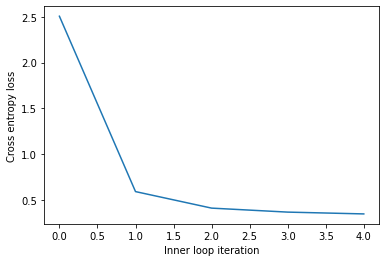

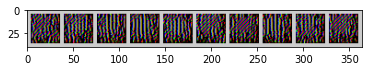

EPOCH: 4 Inner loop losses: 0.992, Train accuracy: 0.12109375, Validation accuracy: 0.109375
EPOCH 4 Final test accuracy: 0.109765625


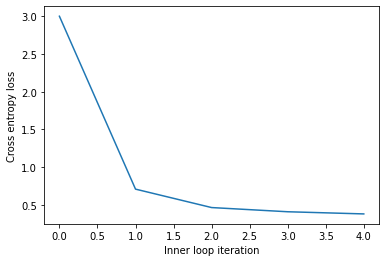

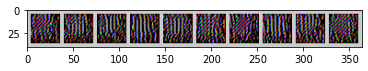

EPOCH: 5 Inner loop losses: 0.955, Train accuracy: 0.07421875, Validation accuracy: 0.0859375
EPOCH 5 Final test accuracy: 0.10146484375


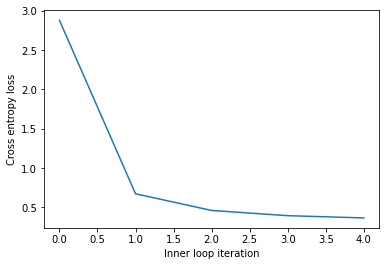

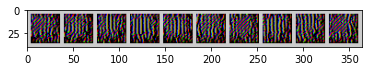

EPOCH: 6 Inner loop losses: 0.897, Train accuracy: 0.125, Validation accuracy: 0.0859375
EPOCH 6 Final test accuracy: 0.10146484375


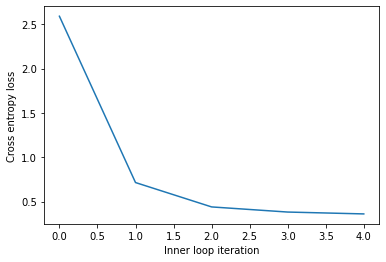

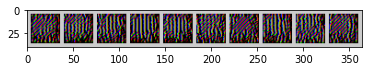

EPOCH: 7 Inner loop losses: 0.881, Train accuracy: 0.12109375, Validation accuracy: 0.09375
EPOCH 7 Final test accuracy: 0.11669921875


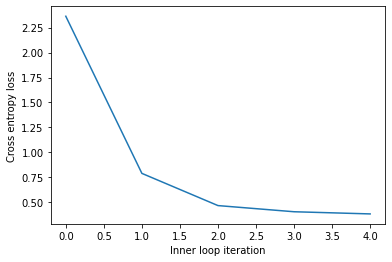

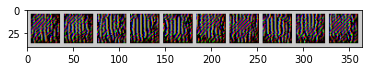

EPOCH: 8 Inner loop losses: 1.188, Train accuracy: 0.08203125, Validation accuracy: 0.1015625
EPOCH 8 Final test accuracy: 0.08125


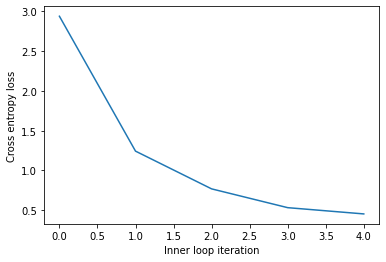

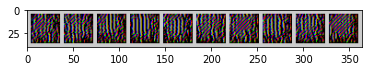

EPOCH: 9 Inner loop losses: 1.197, Train accuracy: 0.09375, Validation accuracy: 0.08984375
EPOCH 9 Final test accuracy: 0.0876953125


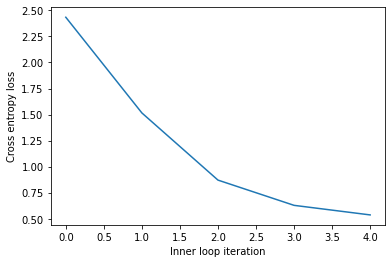

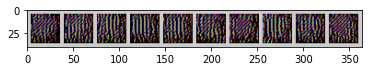

EPOCH: 10 Inner loop losses: 1.099, Train accuracy: 0.1328125, Validation accuracy: 0.09765625
EPOCH 10 Final test accuracy: 0.107421875


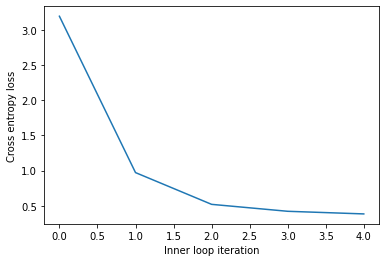

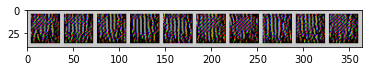

EPOCH: 11 Inner loop losses: 0.925, Train accuracy: 0.07421875, Validation accuracy: 0.1484375
EPOCH 11 Final test accuracy: 0.1064453125


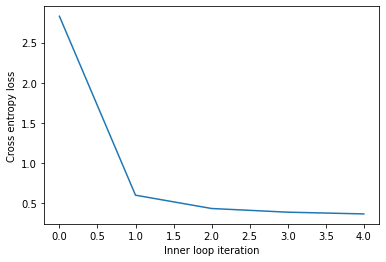

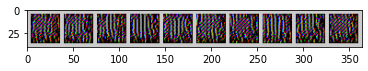

EPOCH: 12 Inner loop losses: 1.018, Train accuracy: 0.12890625, Validation accuracy: 0.09375
EPOCH 12 Final test accuracy: 0.1134765625


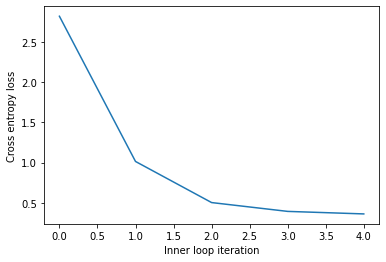

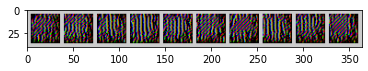

EPOCH: 13 Inner loop losses: 1.282, Train accuracy: 0.08203125, Validation accuracy: 0.0703125
EPOCH 13 Final test accuracy: 0.06962890625


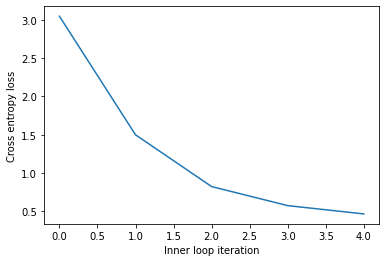

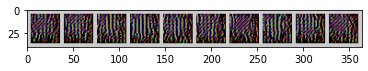

EPOCH: 14 Inner loop losses: 1.257, Train accuracy: 0.0859375, Validation accuracy: 0.1328125
EPOCH 14 Final test accuracy: 0.08984375


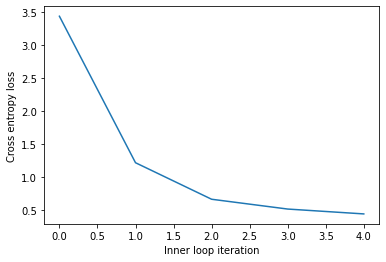

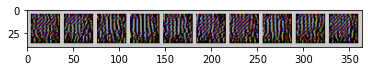

EPOCH: 15 Inner loop losses: 1.127, Train accuracy: 0.11328125, Validation accuracy: 0.1171875
EPOCH 15 Final test accuracy: 0.0765625


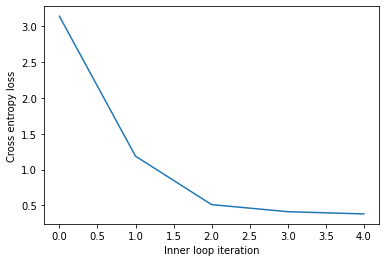

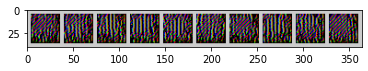

EPOCH: 16 Inner loop losses: 0.993, Train accuracy: 0.1015625, Validation accuracy: 0.12890625
EPOCH 16 Final test accuracy: 0.0859375


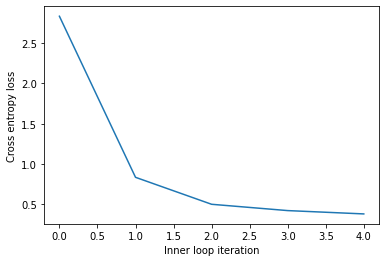

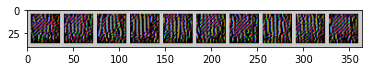

EPOCH: 17 Inner loop losses: 0.847, Train accuracy: 0.078125, Validation accuracy: 0.10546875
EPOCH 17 Final test accuracy: 0.0859375


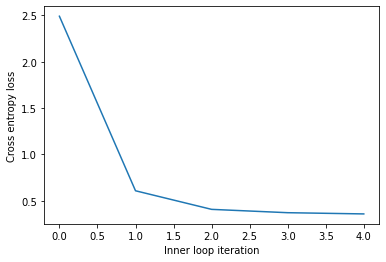

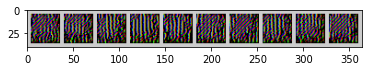

EPOCH: 18 Inner loop losses: 1.011, Train accuracy: 0.125, Validation accuracy: 0.125
EPOCH 18 Final test accuracy: 0.10126953125


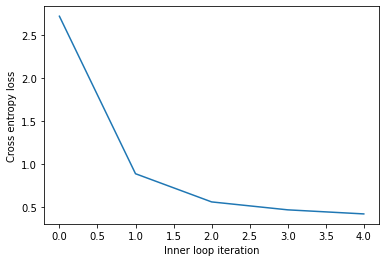

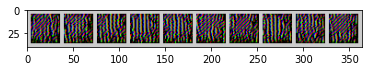

EPOCH: 19 Inner loop losses: 0.956, Train accuracy: 0.12109375, Validation accuracy: 0.08984375
EPOCH 19 Final test accuracy: 0.090625


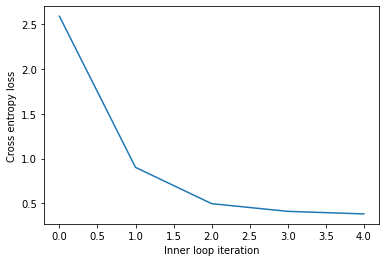

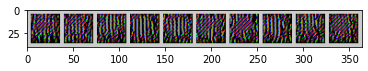

EPOCH: 20 Inner loop losses: 1.146, Train accuracy: 0.1328125, Validation accuracy: 0.07421875
EPOCH 20 Final test accuracy: 0.11220703125


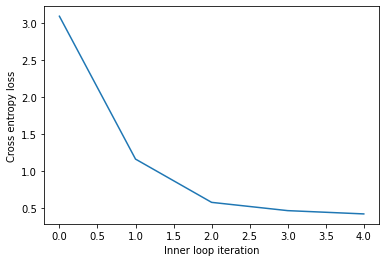

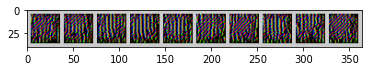

EPOCH: 21 Inner loop losses: 0.834, Train accuracy: 0.06640625, Validation accuracy: 0.07421875
EPOCH 21 Final test accuracy: 0.07841796875


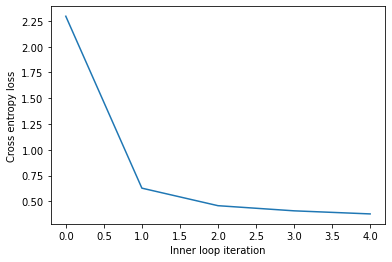

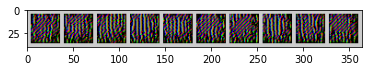

EPOCH: 22 Inner loop losses: 0.965, Train accuracy: 0.09375, Validation accuracy: 0.10546875
EPOCH 22 Final test accuracy: 0.08701171875


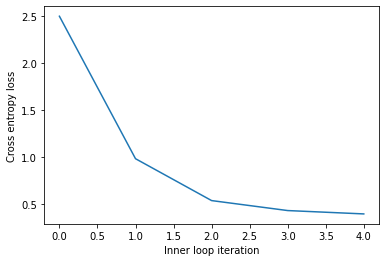

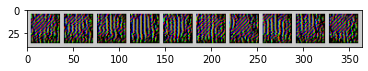

EPOCH: 23 Inner loop losses: 0.903, Train accuracy: 0.07421875, Validation accuracy: 0.08984375
EPOCH 23 Final test accuracy: 0.073828125


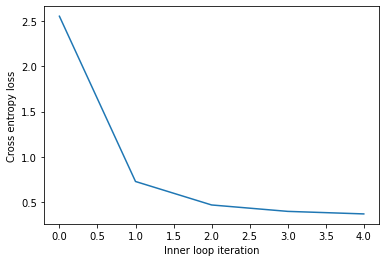

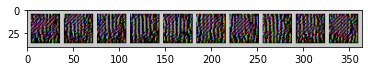

EPOCH: 24 Inner loop losses: 0.826, Train accuracy: 0.12109375, Validation accuracy: 0.0546875
EPOCH 24 Final test accuracy: 0.1037109375


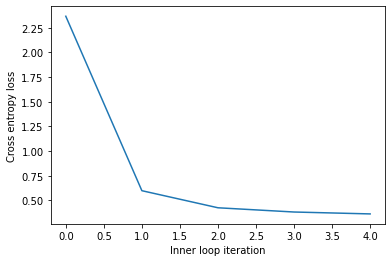

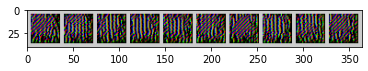

EPOCH: 25 Inner loop losses: 0.92, Train accuracy: 0.09375, Validation accuracy: 0.09765625
EPOCH 25 Final test accuracy: 0.09853515625


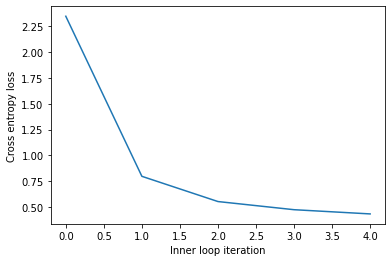

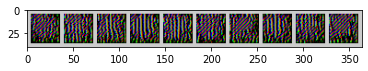

EPOCH: 26 Inner loop losses: 0.888, Train accuracy: 0.10546875, Validation accuracy: 0.11328125
EPOCH 26 Final test accuracy: 0.10263671875


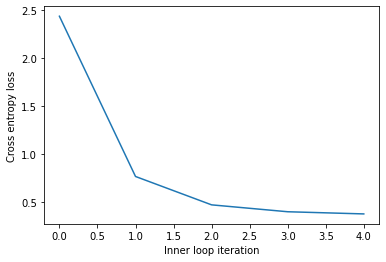

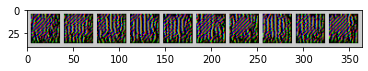

EPOCH: 27 Inner loop losses: 0.864, Train accuracy: 0.08984375, Validation accuracy: 0.08984375
EPOCH 27 Final test accuracy: 0.0974609375


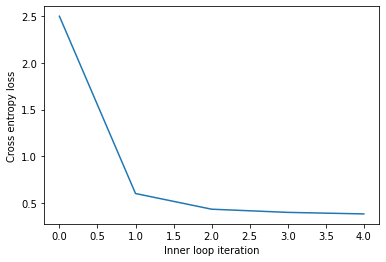

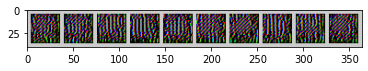

EPOCH: 28 Inner loop losses: 0.935, Train accuracy: 0.078125, Validation accuracy: 0.11328125
EPOCH 28 Final test accuracy: 0.093359375


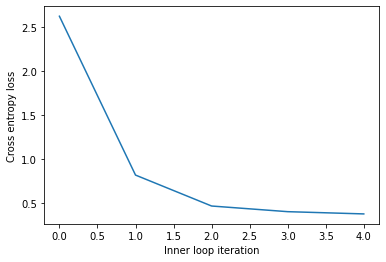

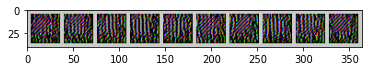

EPOCH: 29 Inner loop losses: 0.901, Train accuracy: 0.08984375, Validation accuracy: 0.0859375
EPOCH 29 Final test accuracy: 0.0962890625


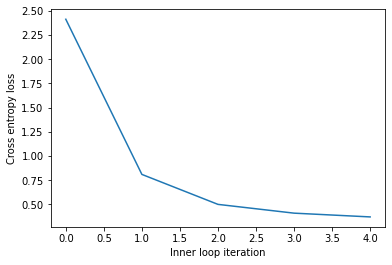

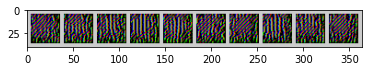

EPOCH: 30 Inner loop losses: 0.883, Train accuracy: 0.140625, Validation accuracy: 0.1171875
EPOCH 30 Final test accuracy: 0.10302734375


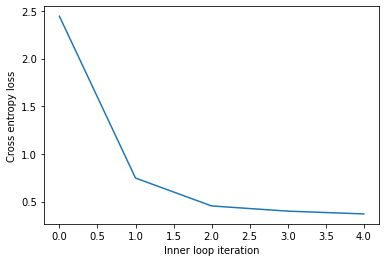

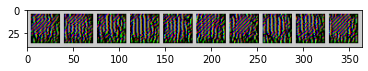

EPOCH: 31 Inner loop losses: 0.879, Train accuracy: 0.1015625, Validation accuracy: 0.078125
EPOCH 31 Final test accuracy: 0.11220703125


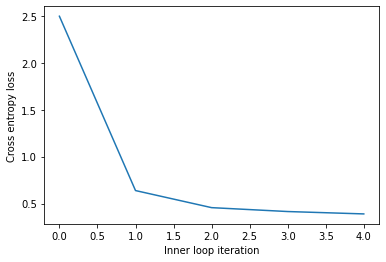

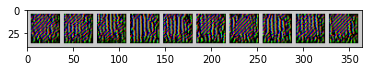

EPOCH: 32 Inner loop losses: 1.056, Train accuracy: 0.11328125, Validation accuracy: 0.06640625
EPOCH 32 Final test accuracy: 0.11845703125


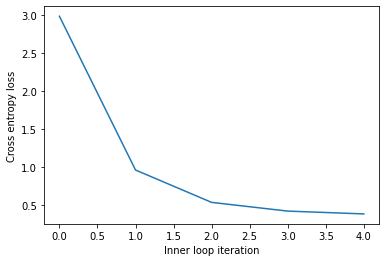

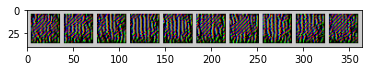

EPOCH: 33 Inner loop losses: 1.052, Train accuracy: 0.109375, Validation accuracy: 0.078125
EPOCH 33 Final test accuracy: 0.10009765625


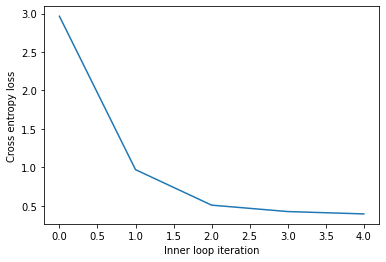

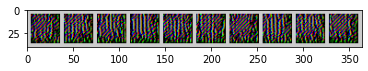

EPOCH: 34 Inner loop losses: 0.876, Train accuracy: 0.0859375, Validation accuracy: 0.1015625
EPOCH 34 Final test accuracy: 0.08193359375


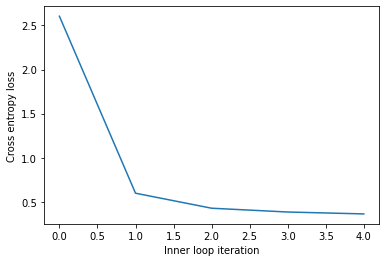

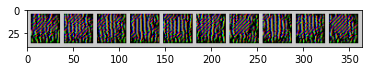

EPOCH: 35 Inner loop losses: 0.943, Train accuracy: 0.046875, Validation accuracy: 0.10546875
EPOCH 35 Final test accuracy: 0.06748046875


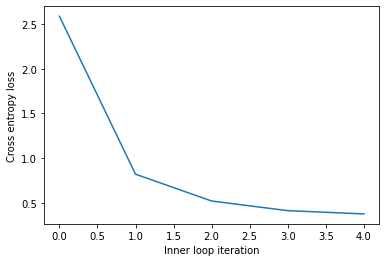

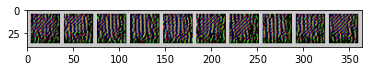

EPOCH: 36 Inner loop losses: 1.132, Train accuracy: 0.125, Validation accuracy: 0.09765625
EPOCH 36 Final test accuracy: 0.11875


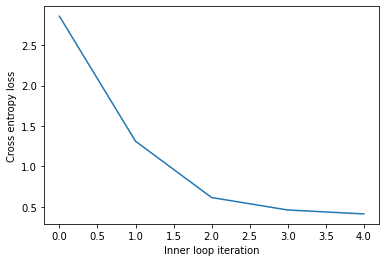

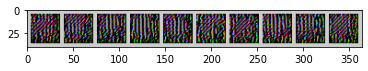

EPOCH: 37 Inner loop losses: 1.188, Train accuracy: 0.109375, Validation accuracy: 0.109375
EPOCH 37 Final test accuracy: 0.08798828125


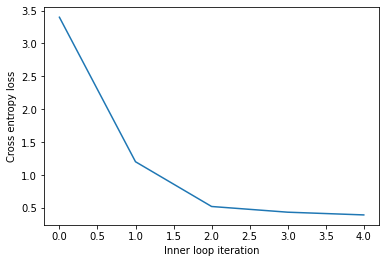

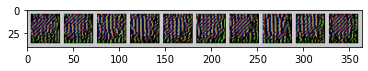

EPOCH: 38 Inner loop losses: 1.073, Train accuracy: 0.10546875, Validation accuracy: 0.09375
EPOCH 38 Final test accuracy: 0.11240234375


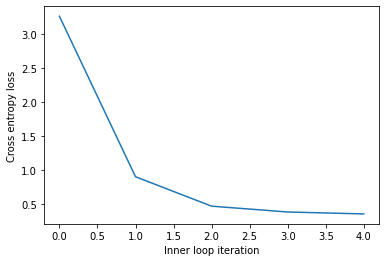

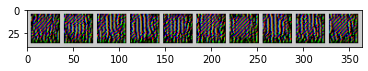

EPOCH: 39 Inner loop losses: 1.13, Train accuracy: 0.109375, Validation accuracy: 0.078125
EPOCH 39 Final test accuracy: 0.0931640625


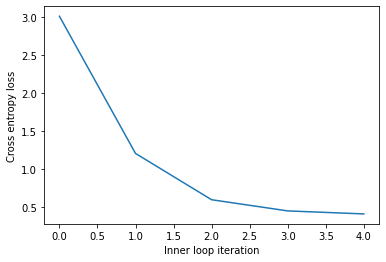

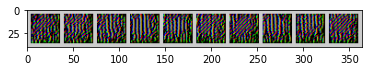

EPOCH: 40 Inner loop losses: 1.03, Train accuracy: 0.11328125, Validation accuracy: 0.07421875
EPOCH 40 Final test accuracy: 0.1041015625


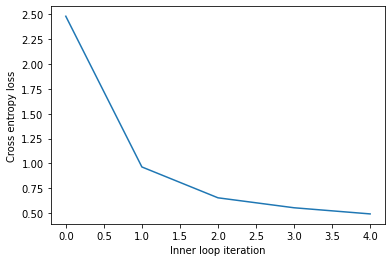

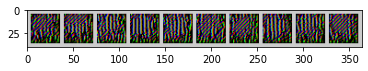

EPOCH: 41 Inner loop losses: 0.933, Train accuracy: 0.125, Validation accuracy: 0.08203125
EPOCH 41 Final test accuracy: 0.09765625


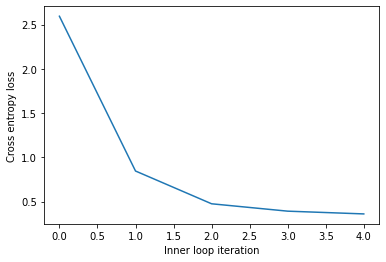

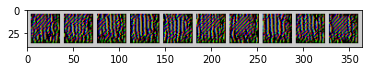

EPOCH: 42 Inner loop losses: 0.859, Train accuracy: 0.0859375, Validation accuracy: 0.046875
EPOCH 42 Final test accuracy: 0.10185546875


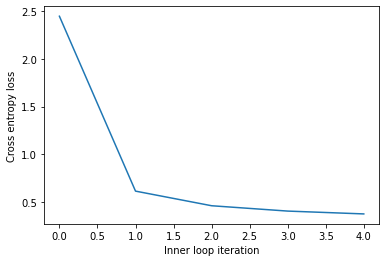

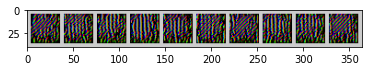

EPOCH: 43 Inner loop losses: 0.888, Train accuracy: 0.1015625, Validation accuracy: 0.109375
EPOCH 43 Final test accuracy: 0.10546875


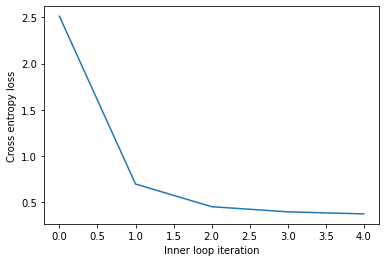

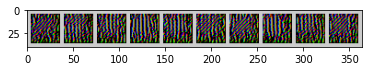

EPOCH: 44 Inner loop losses: 0.998, Train accuracy: 0.15234375, Validation accuracy: 0.13671875
EPOCH 44 Final test accuracy: 0.1076171875


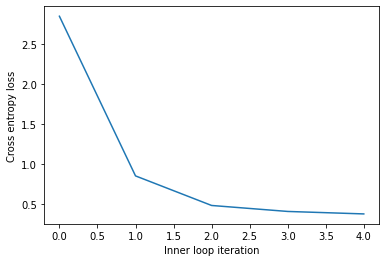

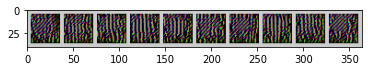

EPOCH: 45 Inner loop losses: 0.988, Train accuracy: 0.09375, Validation accuracy: 0.109375
EPOCH 45 Final test accuracy: 0.083984375


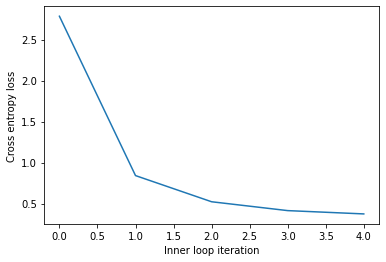

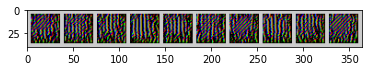

EPOCH: 46 Inner loop losses: 1.047, Train accuracy: 0.0859375, Validation accuracy: 0.1171875
EPOCH 46 Final test accuracy: 0.0990234375


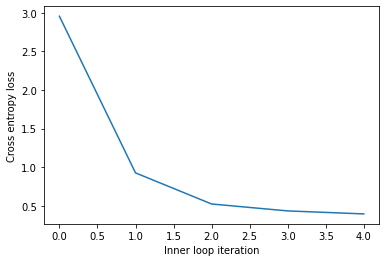

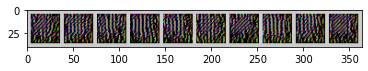

EPOCH: 47 Inner loop losses: 1.155, Train accuracy: 0.078125, Validation accuracy: 0.109375
EPOCH 47 Final test accuracy: 0.10322265625


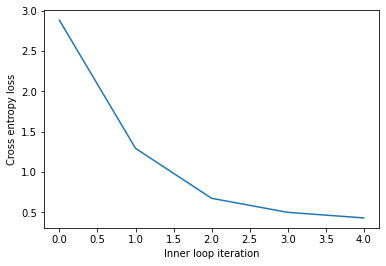

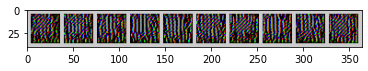

EPOCH: 48 Inner loop losses: 0.907, Train accuracy: 0.10546875, Validation accuracy: 0.109375
EPOCH 48 Final test accuracy: 0.10517578125


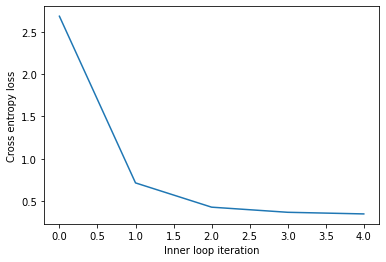

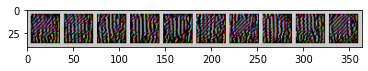

EPOCH: 49 Inner loop losses: 0.851, Train accuracy: 0.09765625, Validation accuracy: 0.11328125
EPOCH 49 Final test accuracy: 0.10087890625


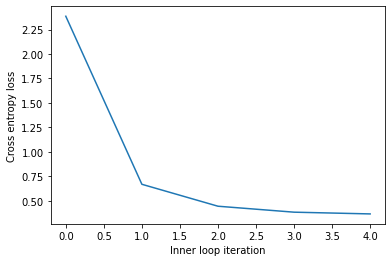

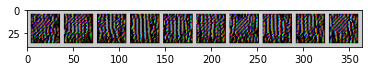

EPOCH: 50 Inner loop losses: 0.952, Train accuracy: 0.15625, Validation accuracy: 0.1171875
EPOCH 50 Final test accuracy: 0.1171875


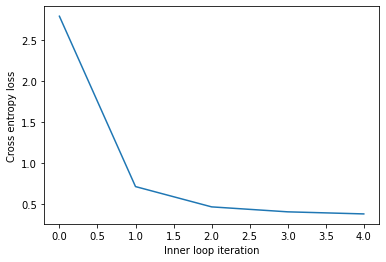

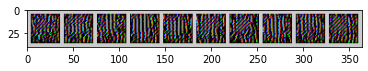

EPOCH: 51 Inner loop losses: 1.052, Train accuracy: 0.10546875, Validation accuracy: 0.09375
EPOCH 51 Final test accuracy: 0.08544921875


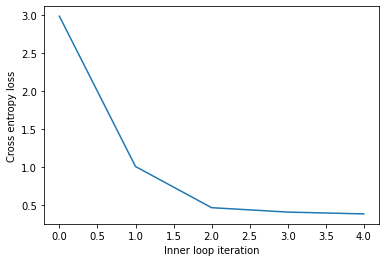

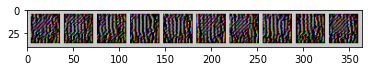

EPOCH: 52 Inner loop losses: 0.89, Train accuracy: 0.0859375, Validation accuracy: 0.11328125
EPOCH 52 Final test accuracy: 0.09833984375


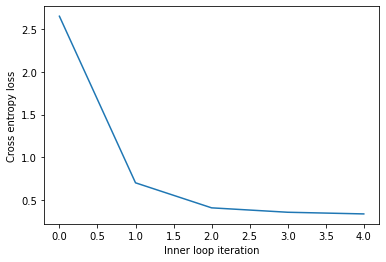

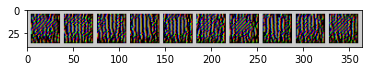

EPOCH: 53 Inner loop losses: 1.067, Train accuracy: 0.08984375, Validation accuracy: 0.1015625
EPOCH 53 Final test accuracy: 0.10771484375


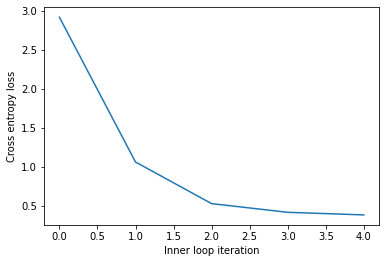

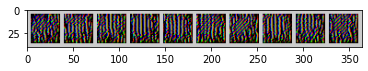

EPOCH: 54 Inner loop losses: 0.986, Train accuracy: 0.06640625, Validation accuracy: 0.1171875
EPOCH 54 Final test accuracy: 0.0853515625


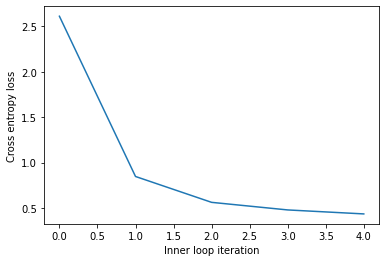

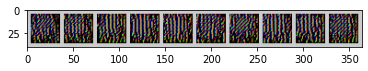

EPOCH: 55 Inner loop losses: 1.272, Train accuracy: 0.1484375, Validation accuracy: 0.10546875
EPOCH 55 Final test accuracy: 0.11708984375


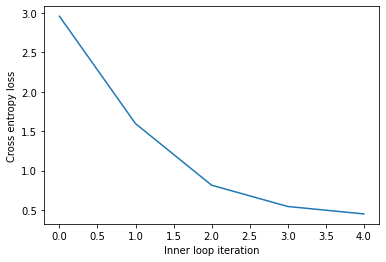

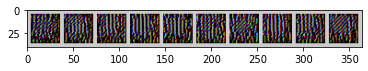

EPOCH: 56 Inner loop losses: 0.992, Train accuracy: 0.09375, Validation accuracy: 0.109375
EPOCH 56 Final test accuracy: 0.09794921875


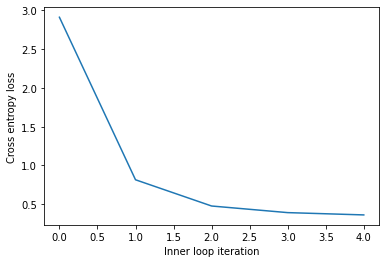

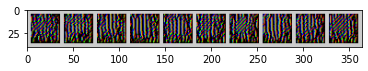

EPOCH: 57 Inner loop losses: 1.036, Train accuracy: 0.0703125, Validation accuracy: 0.09375
EPOCH 57 Final test accuracy: 0.1068359375


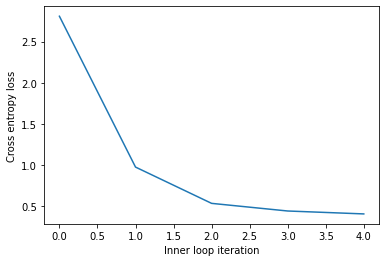

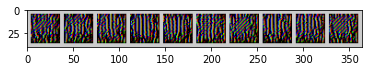

EPOCH: 58 Inner loop losses: 1.105, Train accuracy: 0.1015625, Validation accuracy: 0.1015625
EPOCH 58 Final test accuracy: 0.09912109375


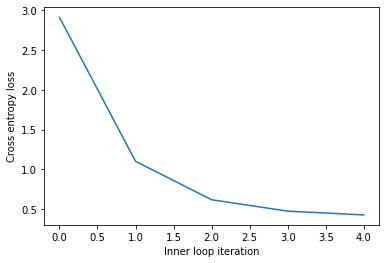

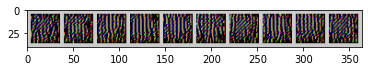

EPOCH: 59 Inner loop losses: 1.465, Train accuracy: 0.09765625, Validation accuracy: 0.11328125
EPOCH 59 Final test accuracy: 0.11455078125


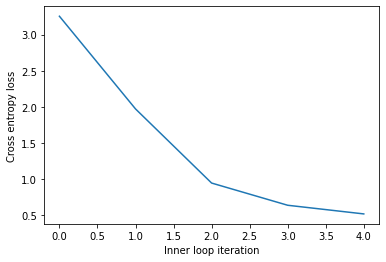

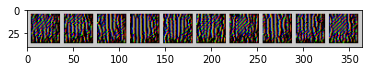

EPOCH: 60 Inner loop losses: 0.854, Train accuracy: 0.11328125, Validation accuracy: 0.1171875
EPOCH 60 Final test accuracy: 0.1080078125


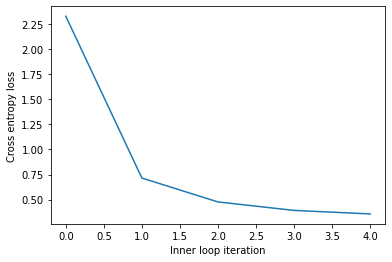

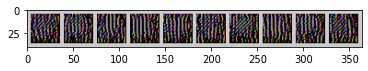

EPOCH: 61 Inner loop losses: 1.26, Train accuracy: 0.1015625, Validation accuracy: 0.1015625
EPOCH 61 Final test accuracy: 0.10009765625


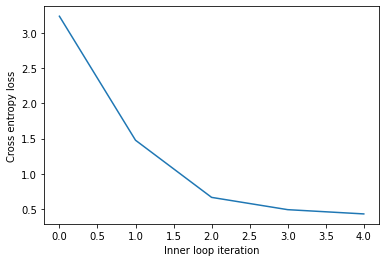

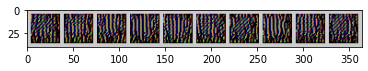

EPOCH: 62 Inner loop losses: 0.979, Train accuracy: 0.10546875, Validation accuracy: 0.12109375
EPOCH 62 Final test accuracy: 0.10888671875


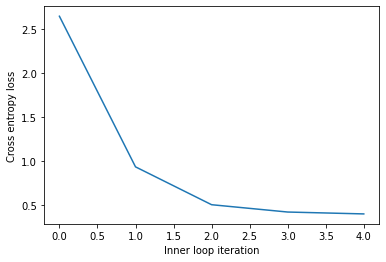

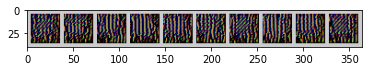

EPOCH: 63 Inner loop losses: 0.938, Train accuracy: 0.09375, Validation accuracy: 0.11328125
EPOCH 63 Final test accuracy: 0.0869140625


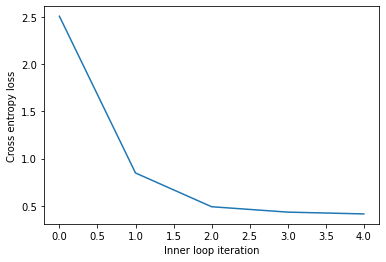

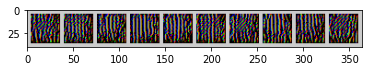

EPOCH: 64 Inner loop losses: 0.947, Train accuracy: 0.08203125, Validation accuracy: 0.1328125
EPOCH 64 Final test accuracy: 0.09501953125


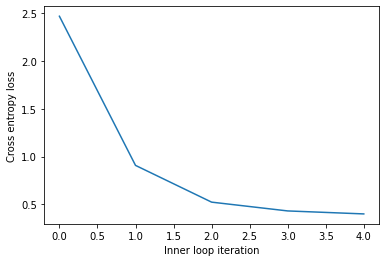

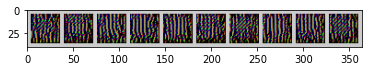

EPOCH: 65 Inner loop losses: 1.126, Train accuracy: 0.05078125, Validation accuracy: 0.1015625
EPOCH 65 Final test accuracy: 0.0873046875


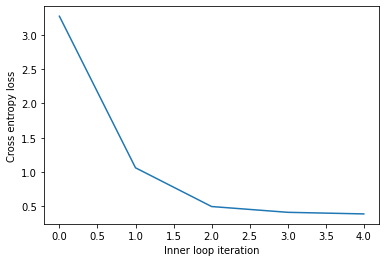

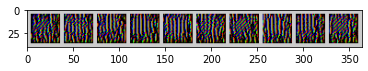

EPOCH: 66 Inner loop losses: 0.935, Train accuracy: 0.125, Validation accuracy: 0.08203125
EPOCH 66 Final test accuracy: 0.1


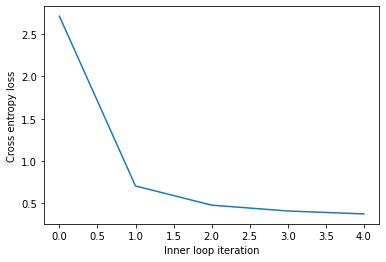

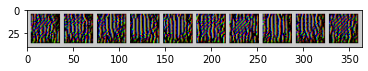

EPOCH: 67 Inner loop losses: 1.025, Train accuracy: 0.125, Validation accuracy: 0.109375
EPOCH 67 Final test accuracy: 0.1142578125


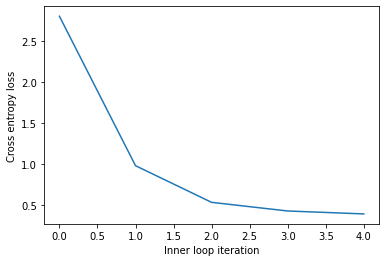

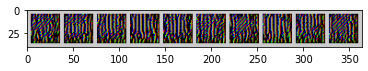

EPOCH: 68 Inner loop losses: 0.901, Train accuracy: 0.11328125, Validation accuracy: 0.10546875
EPOCH 68 Final test accuracy: 0.0986328125


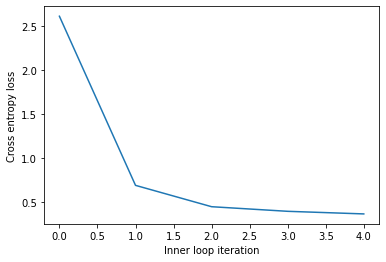

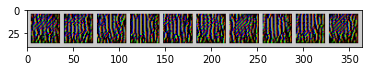

EPOCH: 69 Inner loop losses: 1.163, Train accuracy: 0.09765625, Validation accuracy: 0.10546875
EPOCH 69 Final test accuracy: 0.1185546875


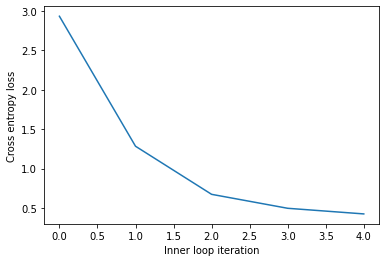

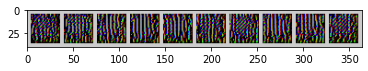

EPOCH: 70 Inner loop losses: 0.93, Train accuracy: 0.07421875, Validation accuracy: 0.08984375
EPOCH 70 Final test accuracy: 0.0830078125


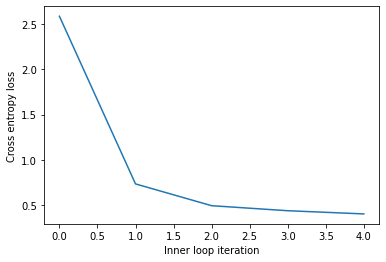

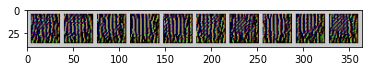

EPOCH: 71 Inner loop losses: 1.309, Train accuracy: 0.078125, Validation accuracy: 0.09375
EPOCH 71 Final test accuracy: 0.08046875


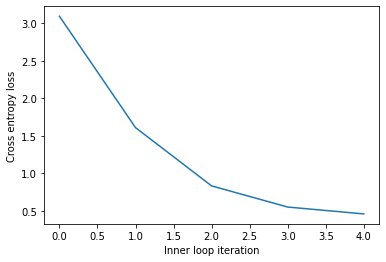

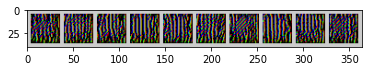

EPOCH: 72 Inner loop losses: 0.906, Train accuracy: 0.125, Validation accuracy: 0.1015625
EPOCH 72 Final test accuracy: 0.1119140625


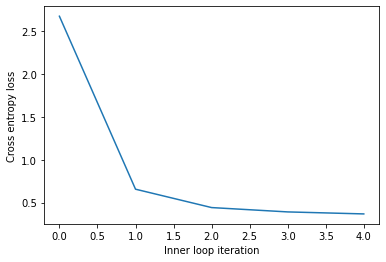

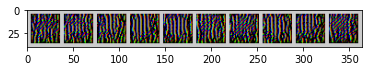

EPOCH: 73 Inner loop losses: 1.071, Train accuracy: 0.07421875, Validation accuracy: 0.0859375
EPOCH 73 Final test accuracy: 0.08681640625


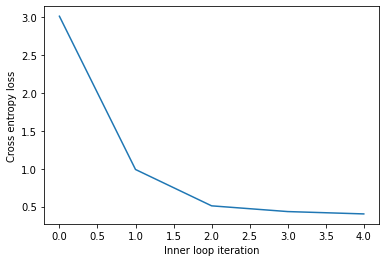

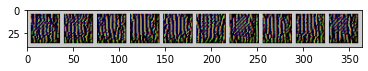

EPOCH: 74 Inner loop losses: 1.115, Train accuracy: 0.1015625, Validation accuracy: 0.09375
EPOCH 74 Final test accuracy: 0.089453125


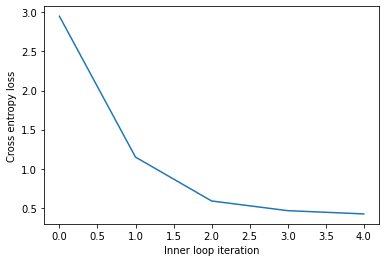

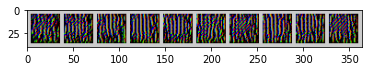

EPOCH: 75 Inner loop losses: 1.073, Train accuracy: 0.078125, Validation accuracy: 0.05859375
EPOCH 75 Final test accuracy: 0.10185546875


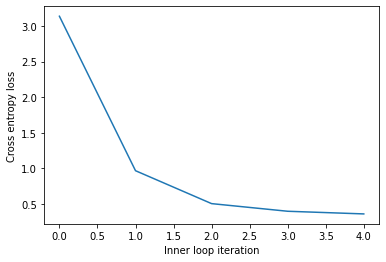

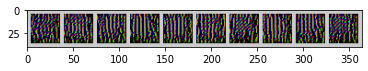

EPOCH: 76 Inner loop losses: 1.035, Train accuracy: 0.09375, Validation accuracy: 0.10546875
EPOCH 76 Final test accuracy: 0.09697265625


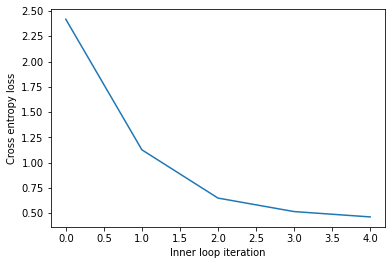

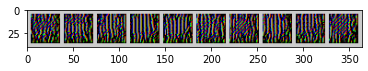

EPOCH: 77 Inner loop losses: 1.236, Train accuracy: 0.1015625, Validation accuracy: 0.125
EPOCH 77 Final test accuracy: 0.1064453125


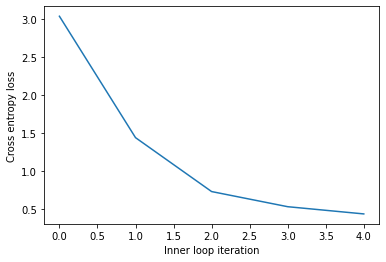

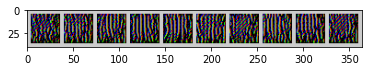

EPOCH: 78 Inner loop losses: 1.033, Train accuracy: 0.09765625, Validation accuracy: 0.08984375
EPOCH 78 Final test accuracy: 0.09013671875


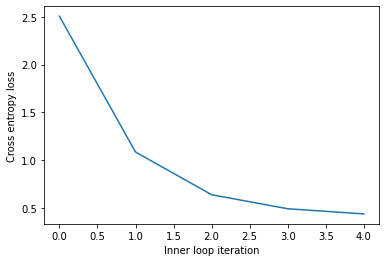

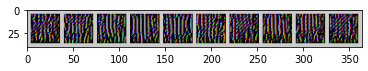

EPOCH: 79 Inner loop losses: 1.304, Train accuracy: 0.07421875, Validation accuracy: 0.08984375
EPOCH 79 Final test accuracy: 0.07705078125


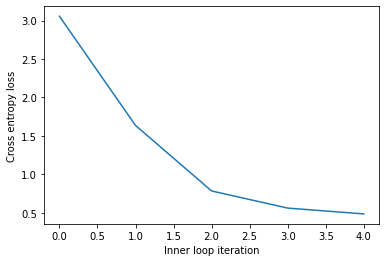

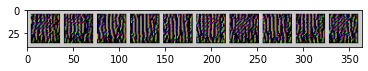

EPOCH: 80 Inner loop losses: 1.014, Train accuracy: 0.09375, Validation accuracy: 0.09765625
EPOCH 80 Final test accuracy: 0.0955078125


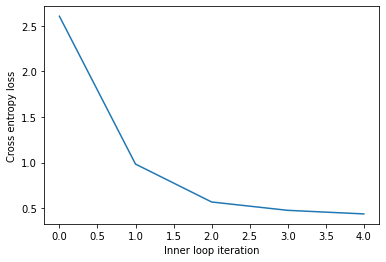

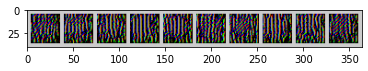

EPOCH: 81 Inner loop losses: 1.281, Train accuracy: 0.1171875, Validation accuracy: 0.09765625
EPOCH 81 Final test accuracy: 0.0896484375


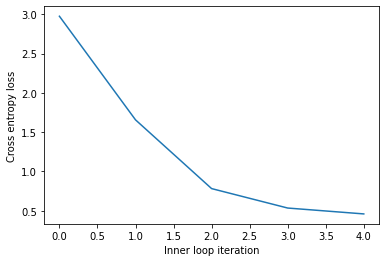

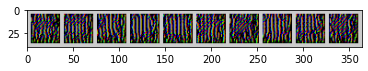

EPOCH: 82 Inner loop losses: 0.817, Train accuracy: 0.109375, Validation accuracy: 0.1328125
EPOCH 82 Final test accuracy: 0.09736328125


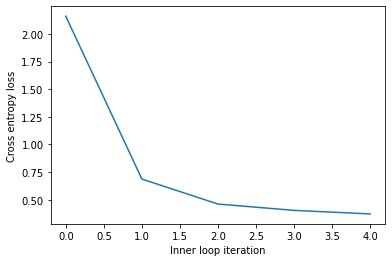

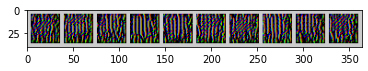

EPOCH: 83 Inner loop losses: 0.994, Train accuracy: 0.07421875, Validation accuracy: 0.0859375
EPOCH 83 Final test accuracy: 0.07255859375


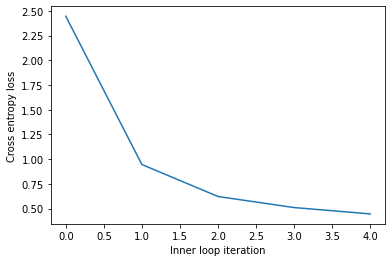

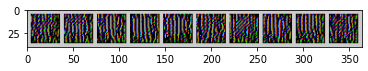

EPOCH: 84 Inner loop losses: 1.213, Train accuracy: 0.1015625, Validation accuracy: 0.08984375
EPOCH 84 Final test accuracy: 0.10732421875


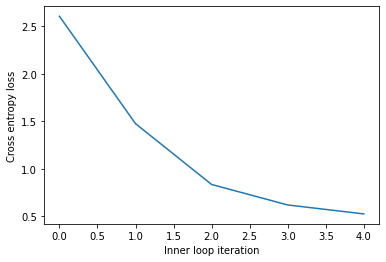

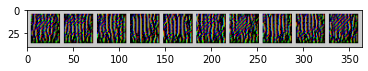

EPOCH: 85 Inner loop losses: 1.157, Train accuracy: 0.1015625, Validation accuracy: 0.09375
EPOCH 85 Final test accuracy: 0.0939453125


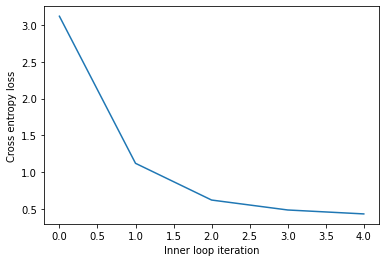

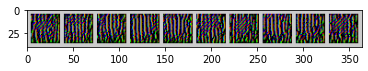

EPOCH: 86 Inner loop losses: 1.0, Train accuracy: 0.10546875, Validation accuracy: 0.08984375
EPOCH 86 Final test accuracy: 0.09375


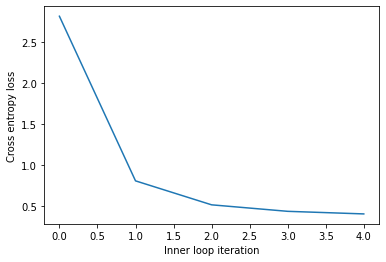

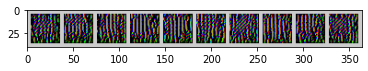

EPOCH: 87 Inner loop losses: 0.905, Train accuracy: 0.11328125, Validation accuracy: 0.09765625
EPOCH 87 Final test accuracy: 0.11025390625


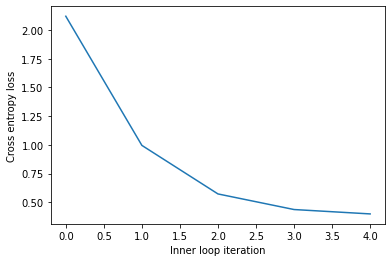

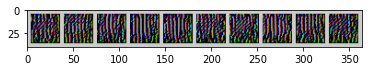

EPOCH: 88 Inner loop losses: 0.899, Train accuracy: 0.15234375, Validation accuracy: 0.0859375
EPOCH 88 Final test accuracy: 0.11025390625


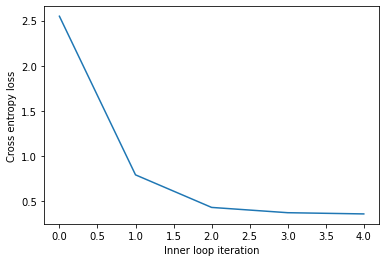

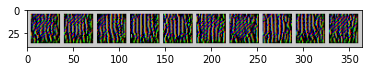

EPOCH: 89 Inner loop losses: 1.197, Train accuracy: 0.078125, Validation accuracy: 0.12109375
EPOCH 89 Final test accuracy: 0.0955078125


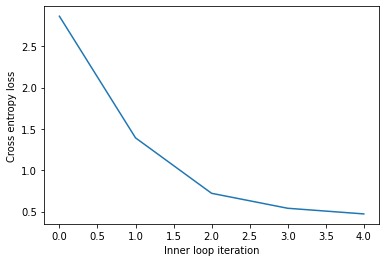

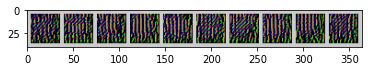

EPOCH: 90 Inner loop losses: 0.931, Train accuracy: 0.0859375, Validation accuracy: 0.11328125
EPOCH 90 Final test accuracy: 0.10234375


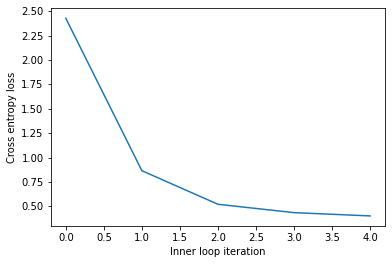

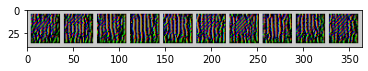

EPOCH: 91 Inner loop losses: 0.981, Train accuracy: 0.09765625, Validation accuracy: 0.1015625
EPOCH 91 Final test accuracy: 0.1095703125


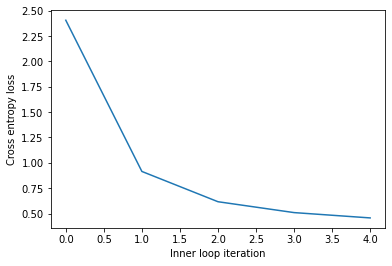

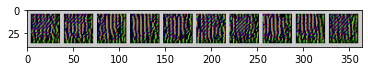

EPOCH: 92 Inner loop losses: 0.96, Train accuracy: 0.09765625, Validation accuracy: 0.08984375
EPOCH 92 Final test accuracy: 0.0875


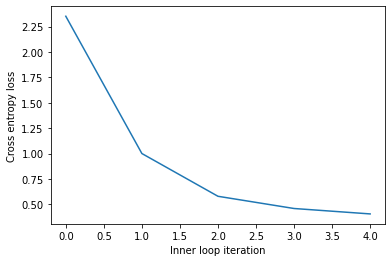

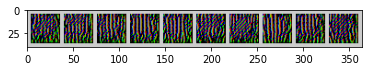

EPOCH: 93 Inner loop losses: 1.207, Train accuracy: 0.0703125, Validation accuracy: 0.0859375
EPOCH 93 Final test accuracy: 0.10927734375


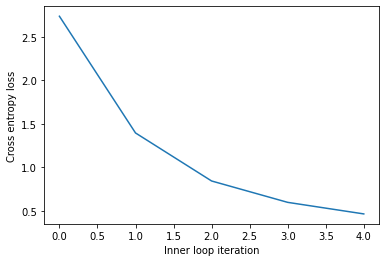

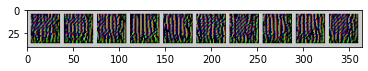

EPOCH: 94 Inner loop losses: 0.995, Train accuracy: 0.12109375, Validation accuracy: 0.09375
EPOCH 94 Final test accuracy: 0.09423828125


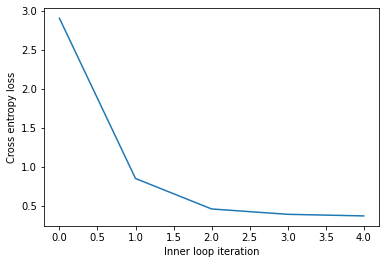

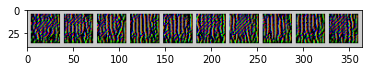

EPOCH: 95 Inner loop losses: 0.885, Train accuracy: 0.12109375, Validation accuracy: 0.07421875
EPOCH 95 Final test accuracy: 0.1140625


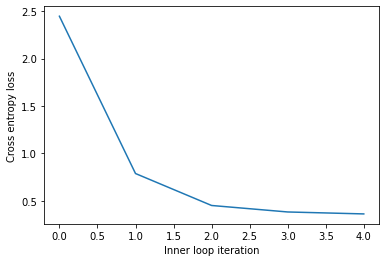

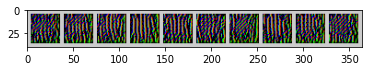

EPOCH: 96 Inner loop losses: 1.069, Train accuracy: 0.09375, Validation accuracy: 0.09765625
EPOCH 96 Final test accuracy: 0.106640625


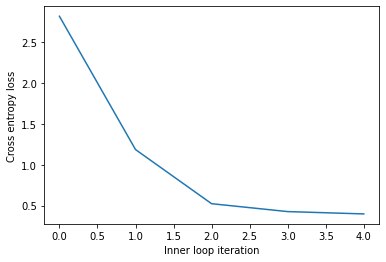

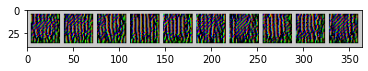

EPOCH: 97 Inner loop losses: 1.002, Train accuracy: 0.1171875, Validation accuracy: 0.09765625
EPOCH 97 Final test accuracy: 0.14306640625


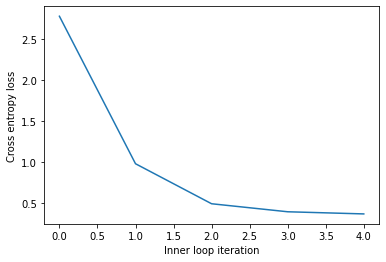

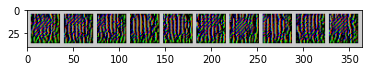

EPOCH: 98 Inner loop losses: 0.91, Train accuracy: 0.11328125, Validation accuracy: 0.09375
EPOCH 98 Final test accuracy: 0.09833984375


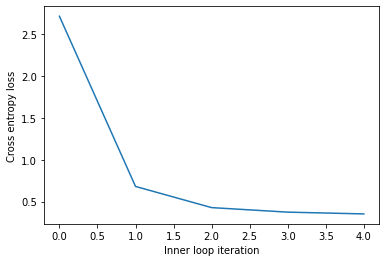

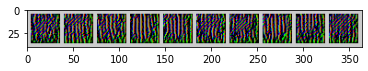

EPOCH: 99 Inner loop losses: 0.883, Train accuracy: 0.07421875, Validation accuracy: 0.09765625
EPOCH 99 Final test accuracy: 0.0943359375


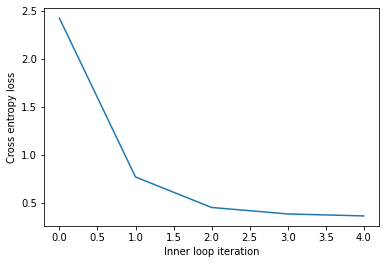

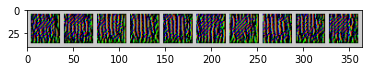

EPOCH: 100 Inner loop losses: 1.029, Train accuracy: 0.11328125, Validation accuracy: 0.1328125
EPOCH 100 Final test accuracy: 0.08330078125


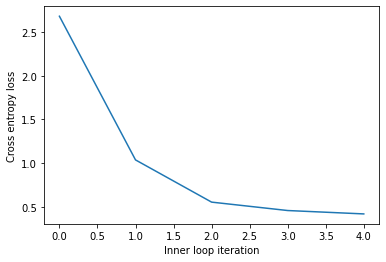

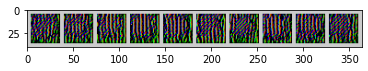

EPOCH: 101 Inner loop losses: 0.936, Train accuracy: 0.09375, Validation accuracy: 0.1171875
EPOCH 101 Final test accuracy: 0.0916015625


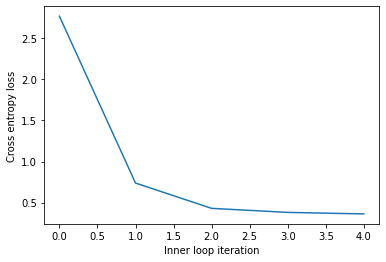

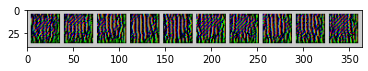

EPOCH: 102 Inner loop losses: 1.35, Train accuracy: 0.08203125, Validation accuracy: 0.1015625
EPOCH 102 Final test accuracy: 0.07998046875


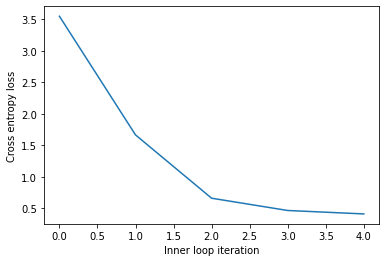

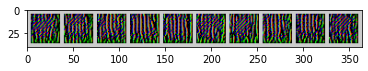

EPOCH: 103 Inner loop losses: 0.899, Train accuracy: 0.1171875, Validation accuracy: 0.109375
EPOCH 103 Final test accuracy: 0.11572265625


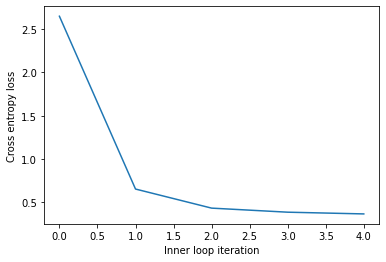

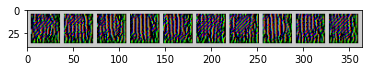

EPOCH: 104 Inner loop losses: 1.104, Train accuracy: 0.1015625, Validation accuracy: 0.109375
EPOCH 104 Final test accuracy: 0.10234375


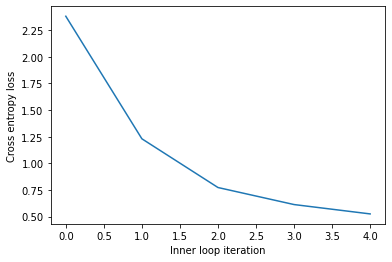

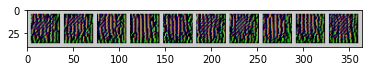

EPOCH: 105 Inner loop losses: 0.893, Train accuracy: 0.08203125, Validation accuracy: 0.125
EPOCH 105 Final test accuracy: 0.0927734375


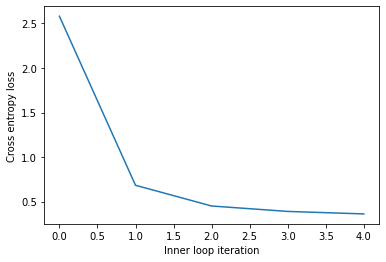

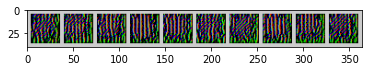

EPOCH: 106 Inner loop losses: 0.864, Train accuracy: 0.07421875, Validation accuracy: 0.078125
EPOCH 106 Final test accuracy: 0.0794921875


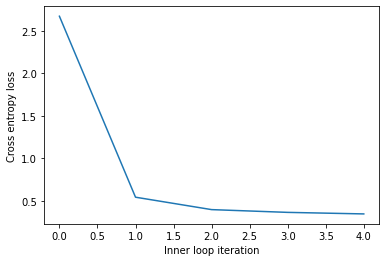

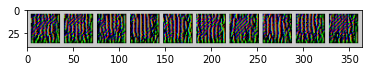

EPOCH: 107 Inner loop losses: 0.849, Train accuracy: 0.1171875, Validation accuracy: 0.109375
EPOCH 107 Final test accuracy: 0.08896484375


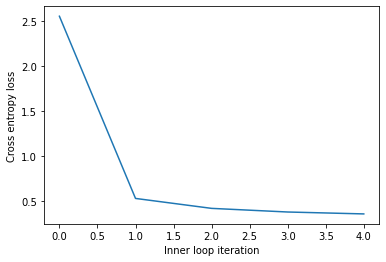

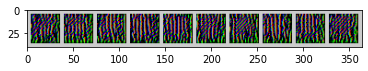

EPOCH: 108 Inner loop losses: 0.917, Train accuracy: 0.16015625, Validation accuracy: 0.078125
EPOCH 108 Final test accuracy: 0.1013671875


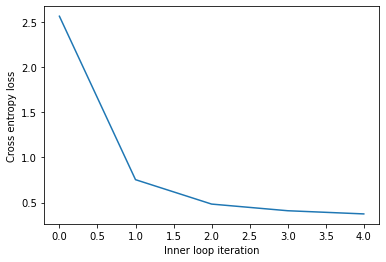

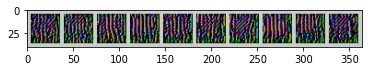

EPOCH: 109 Inner loop losses: 1.169, Train accuracy: 0.0625, Validation accuracy: 0.13671875
EPOCH 109 Final test accuracy: 0.07626953125


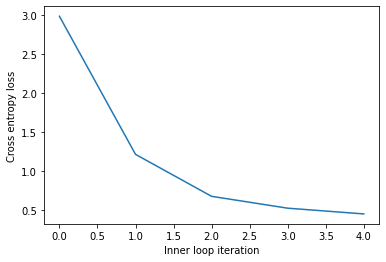

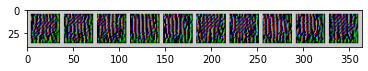

EPOCH: 110 Inner loop losses: 0.958, Train accuracy: 0.11328125, Validation accuracy: 0.078125
EPOCH 110 Final test accuracy: 0.0998046875


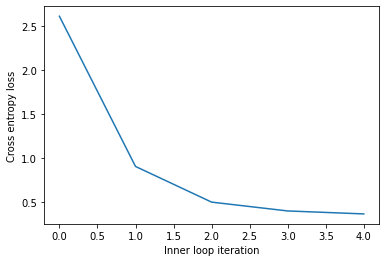

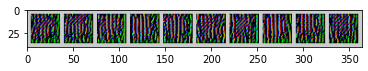

EPOCH: 111 Inner loop losses: 0.966, Train accuracy: 0.08203125, Validation accuracy: 0.1171875
EPOCH 111 Final test accuracy: 0.076953125


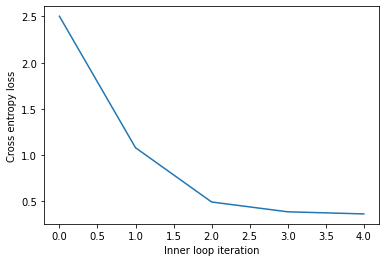

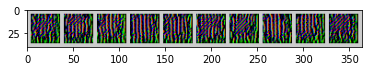

EPOCH: 112 Inner loop losses: 0.997, Train accuracy: 0.1015625, Validation accuracy: 0.1015625
EPOCH 112 Final test accuracy: 0.08466796875


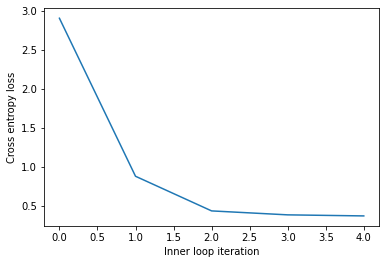

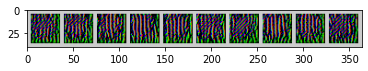

EPOCH: 113 Inner loop losses: 1.004, Train accuracy: 0.09375, Validation accuracy: 0.0703125
EPOCH 113 Final test accuracy: 0.1060546875


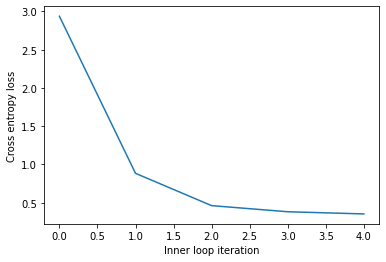

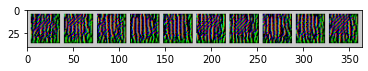

EPOCH: 114 Inner loop losses: 1.041, Train accuracy: 0.09765625, Validation accuracy: 0.12890625
EPOCH 114 Final test accuracy: 0.08984375


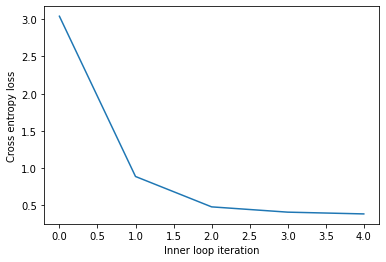

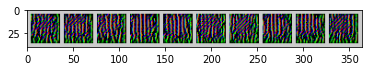

EPOCH: 115 Inner loop losses: 1.033, Train accuracy: 0.1015625, Validation accuracy: 0.09375
EPOCH 115 Final test accuracy: 0.0873046875


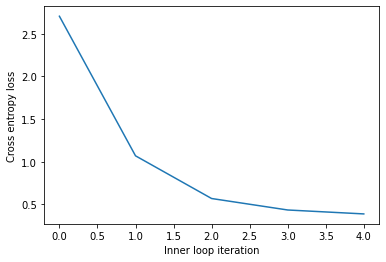

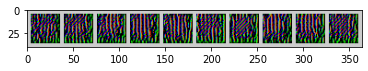

EPOCH: 116 Inner loop losses: 1.044, Train accuracy: 0.09765625, Validation accuracy: 0.07421875
EPOCH 116 Final test accuracy: 0.10537109375


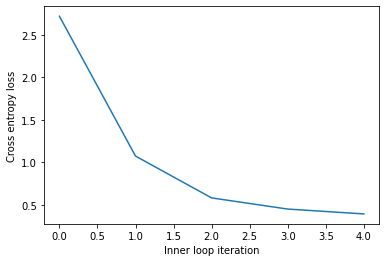

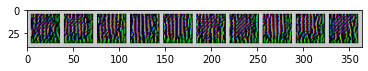

EPOCH: 117 Inner loop losses: 0.889, Train accuracy: 0.1015625, Validation accuracy: 0.1484375
EPOCH 117 Final test accuracy: 0.112890625


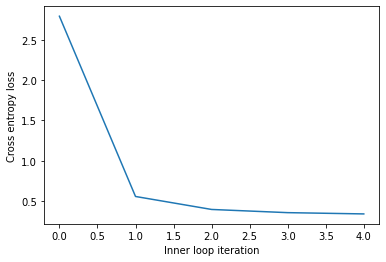

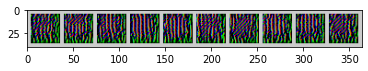

EPOCH: 118 Inner loop losses: 1.03, Train accuracy: 0.06640625, Validation accuracy: 0.0703125
EPOCH 118 Final test accuracy: 0.0845703125


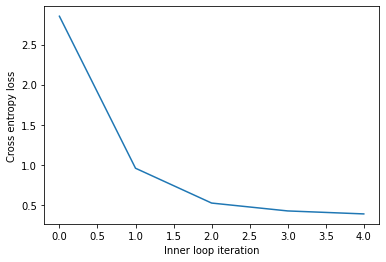

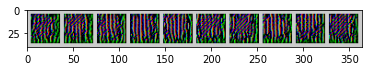

EPOCH: 119 Inner loop losses: 0.977, Train accuracy: 0.09375, Validation accuracy: 0.12109375
EPOCH 119 Final test accuracy: 0.09228515625


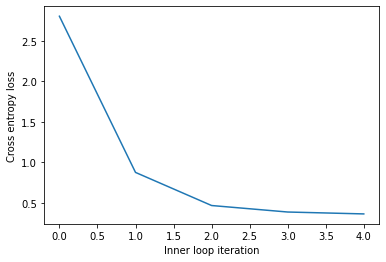

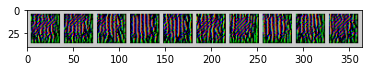

EPOCH: 120 Inner loop losses: 1.233, Train accuracy: 0.09765625, Validation accuracy: 0.0859375
EPOCH 120 Final test accuracy: 0.10263671875


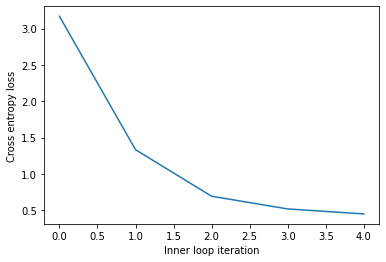

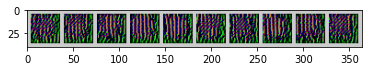

EPOCH: 121 Inner loop losses: 1.03, Train accuracy: 0.09765625, Validation accuracy: 0.0859375
EPOCH 121 Final test accuracy: 0.09970703125


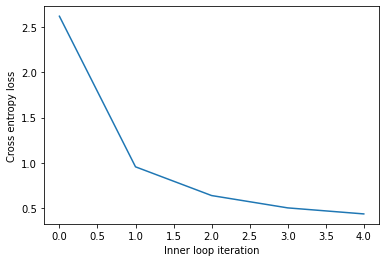

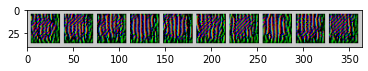

EPOCH: 122 Inner loop losses: 0.877, Train accuracy: 0.06640625, Validation accuracy: 0.12109375
EPOCH 122 Final test accuracy: 0.07890625


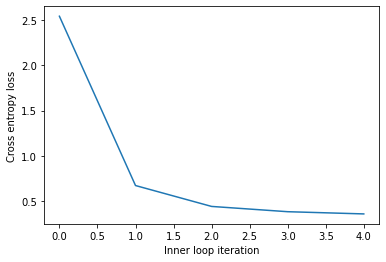

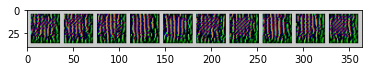

EPOCH: 123 Inner loop losses: 1.071, Train accuracy: 0.08203125, Validation accuracy: 0.12109375
EPOCH 123 Final test accuracy: 0.09580078125


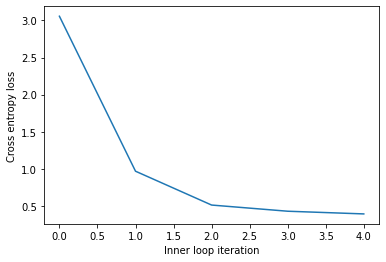

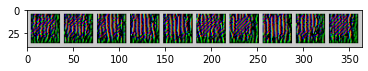

EPOCH: 124 Inner loop losses: 1.149, Train accuracy: 0.05859375, Validation accuracy: 0.0859375
EPOCH 124 Final test accuracy: 0.11240234375


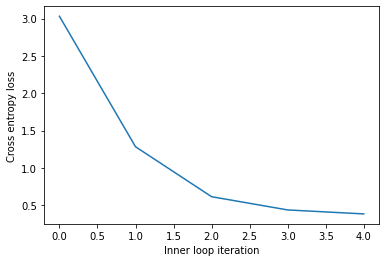

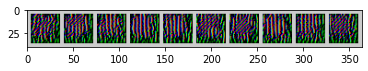

EPOCH: 125 Inner loop losses: 0.846, Train accuracy: 0.12890625, Validation accuracy: 0.1171875
EPOCH 125 Final test accuracy: 0.08466796875


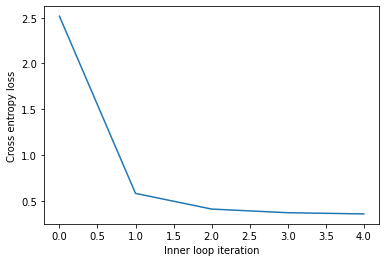

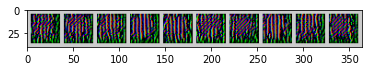

EPOCH: 126 Inner loop losses: 0.798, Train accuracy: 0.0859375, Validation accuracy: 0.09765625
EPOCH 126 Final test accuracy: 0.091015625


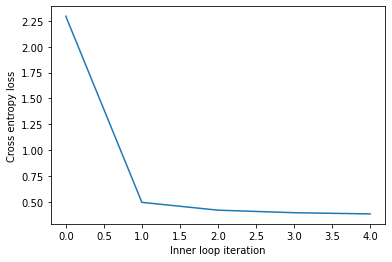

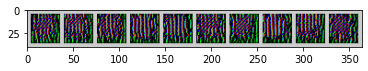

EPOCH: 127 Inner loop losses: 0.987, Train accuracy: 0.1171875, Validation accuracy: 0.10546875
EPOCH 127 Final test accuracy: 0.09208984375


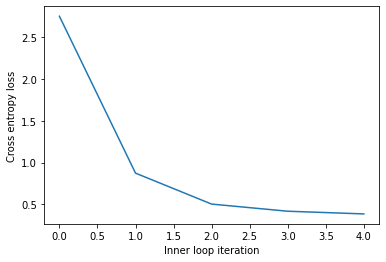

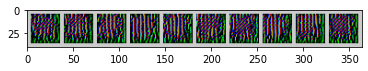

EPOCH: 128 Inner loop losses: 0.864, Train accuracy: 0.078125, Validation accuracy: 0.10546875
EPOCH 128 Final test accuracy: 0.09814453125


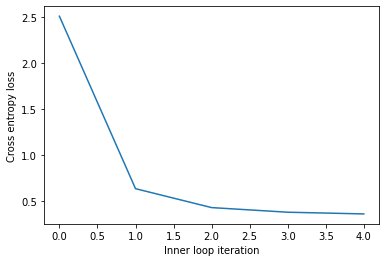

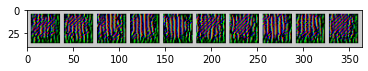

EPOCH: 129 Inner loop losses: 1.176, Train accuracy: 0.0859375, Validation accuracy: 0.09765625
EPOCH 129 Final test accuracy: 0.09931640625


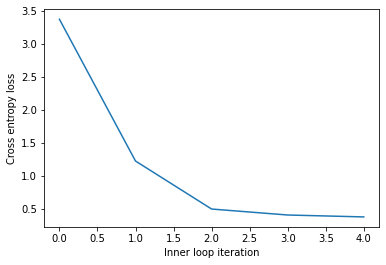

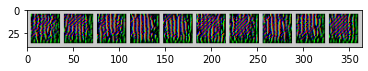

EPOCH: 130 Inner loop losses: 0.872, Train accuracy: 0.1015625, Validation accuracy: 0.06640625
EPOCH 130 Final test accuracy: 0.09462890625


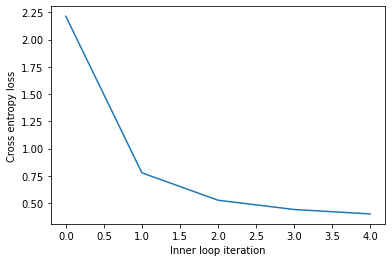

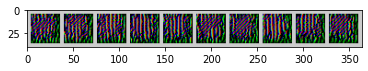

EPOCH: 131 Inner loop losses: 0.979, Train accuracy: 0.11328125, Validation accuracy: 0.1171875
EPOCH 131 Final test accuracy: 0.10439453125


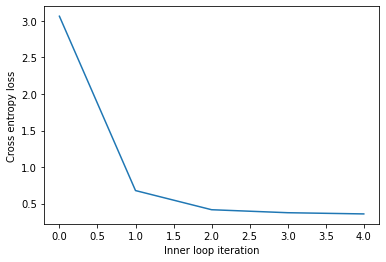

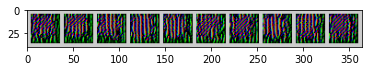

EPOCH: 132 Inner loop losses: 0.871, Train accuracy: 0.109375, Validation accuracy: 0.12109375
EPOCH 132 Final test accuracy: 0.1021484375


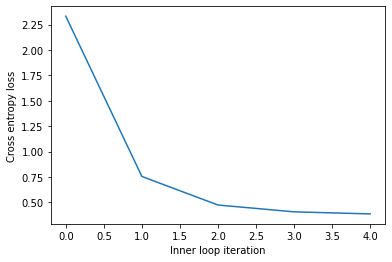

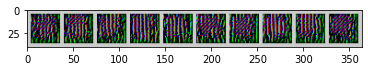

EPOCH: 133 Inner loop losses: 1.061, Train accuracy: 0.10546875, Validation accuracy: 0.109375
EPOCH 133 Final test accuracy: 0.1005859375


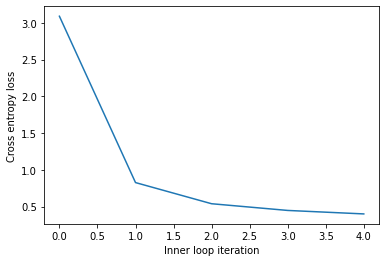

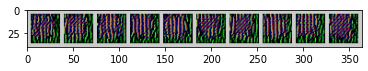

EPOCH: 134 Inner loop losses: 0.887, Train accuracy: 0.09765625, Validation accuracy: 0.08984375
EPOCH 134 Final test accuracy: 0.10439453125


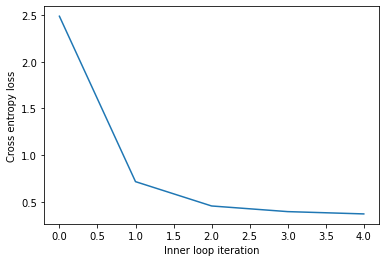

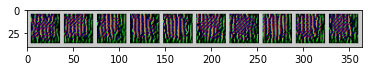

EPOCH: 135 Inner loop losses: 0.963, Train accuracy: 0.06640625, Validation accuracy: 0.08203125
EPOCH 135 Final test accuracy: 0.092578125


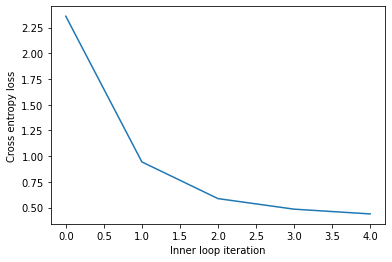

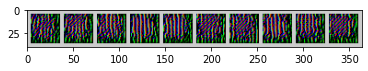

EPOCH: 136 Inner loop losses: 1.013, Train accuracy: 0.08203125, Validation accuracy: 0.08203125
EPOCH 136 Final test accuracy: 0.08291015625


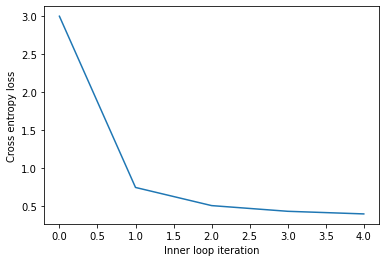

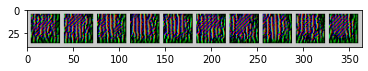

EPOCH: 137 Inner loop losses: 1.042, Train accuracy: 0.1015625, Validation accuracy: 0.0859375
EPOCH 137 Final test accuracy: 0.0931640625


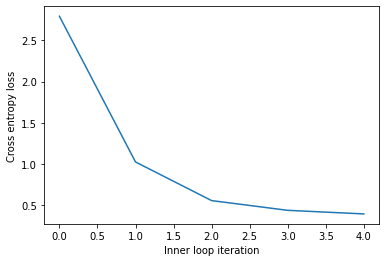

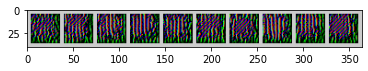

EPOCH: 138 Inner loop losses: 0.943, Train accuracy: 0.07421875, Validation accuracy: 0.09375
EPOCH 138 Final test accuracy: 0.0857421875


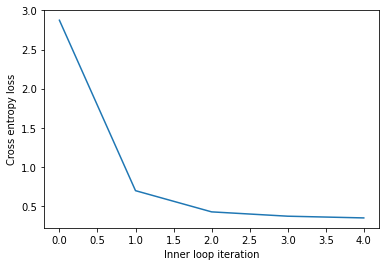

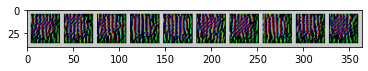

EPOCH: 139 Inner loop losses: 1.089, Train accuracy: 0.125, Validation accuracy: 0.10546875
EPOCH 139 Final test accuracy: 0.10791015625


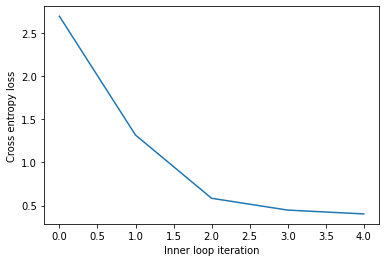

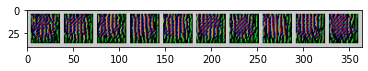

EPOCH: 140 Inner loop losses: 0.933, Train accuracy: 0.06640625, Validation accuracy: 0.07421875
EPOCH 140 Final test accuracy: 0.07763671875


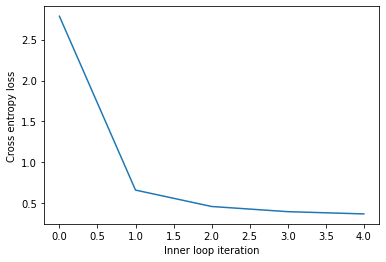

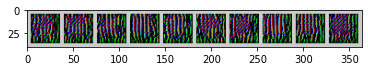

EPOCH: 141 Inner loop losses: 0.958, Train accuracy: 0.08203125, Validation accuracy: 0.09765625
EPOCH 141 Final test accuracy: 0.08916015625


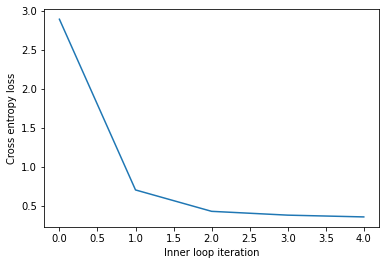

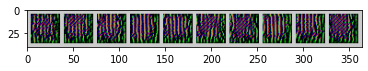

EPOCH: 142 Inner loop losses: 0.994, Train accuracy: 0.10546875, Validation accuracy: 0.09765625
EPOCH 142 Final test accuracy: 0.09013671875


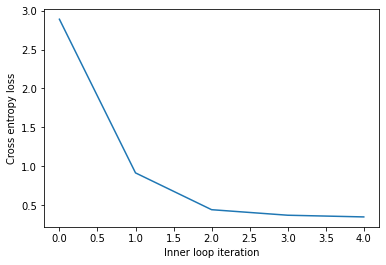

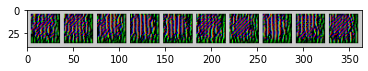

EPOCH: 143 Inner loop losses: 1.167, Train accuracy: 0.1015625, Validation accuracy: 0.09375
EPOCH 143 Final test accuracy: 0.11044921875


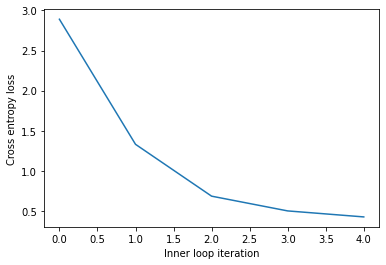

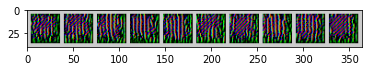

EPOCH: 144 Inner loop losses: 0.98, Train accuracy: 0.109375, Validation accuracy: 0.140625
EPOCH 144 Final test accuracy: 0.097265625


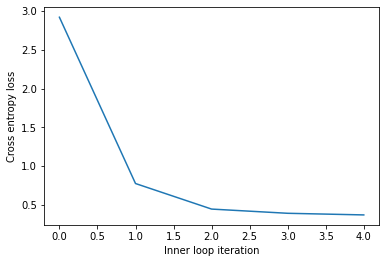

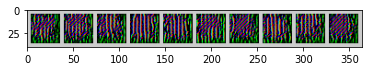

EPOCH: 145 Inner loop losses: 0.879, Train accuracy: 0.12109375, Validation accuracy: 0.08203125
EPOCH 145 Final test accuracy: 0.11201171875


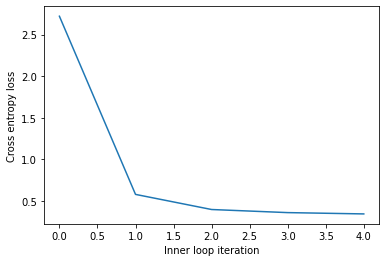

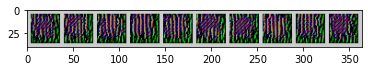

EPOCH: 146 Inner loop losses: 1.114, Train accuracy: 0.09765625, Validation accuracy: 0.10546875
EPOCH 146 Final test accuracy: 0.107421875


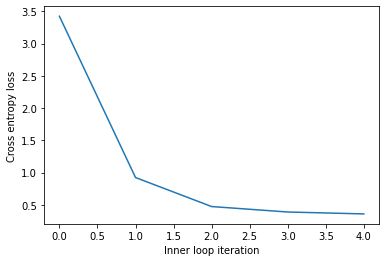

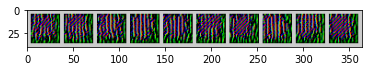

EPOCH: 147 Inner loop losses: 1.032, Train accuracy: 0.0859375, Validation accuracy: 0.10546875
EPOCH 147 Final test accuracy: 0.08388671875


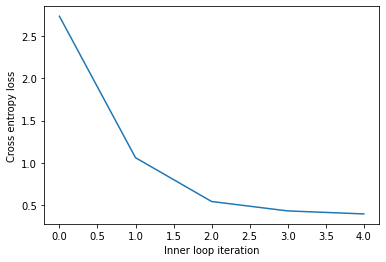

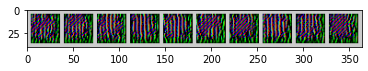

EPOCH: 148 Inner loop losses: 0.953, Train accuracy: 0.09765625, Validation accuracy: 0.10546875
EPOCH 148 Final test accuracy: 0.07646484375


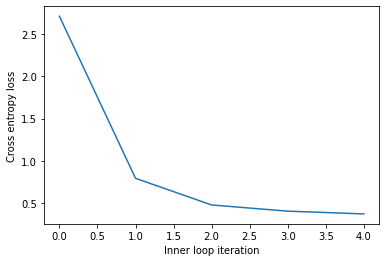

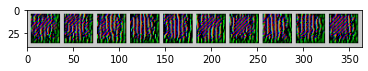

EPOCH: 149 Inner loop losses: 0.973, Train accuracy: 0.078125, Validation accuracy: 0.08203125
EPOCH 149 Final test accuracy: 0.10810546875


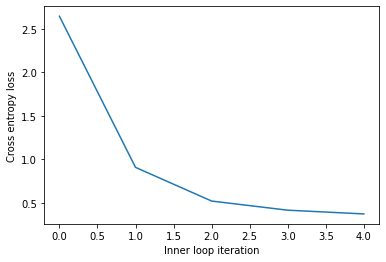

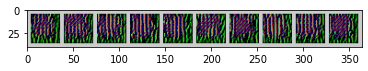

EPOCH: 150 Inner loop losses: 0.72, Train accuracy: 0.08984375, Validation accuracy: 0.125
EPOCH 150 Final test accuracy: 0.10263671875


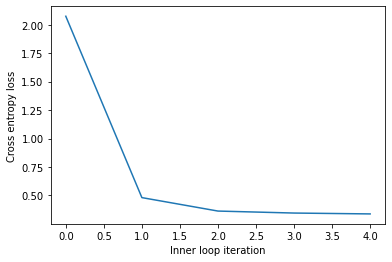

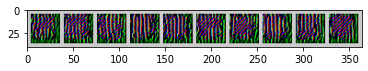

EPOCH: 151 Inner loop losses: 0.923, Train accuracy: 0.0703125, Validation accuracy: 0.109375
EPOCH 151 Final test accuracy: 0.0845703125


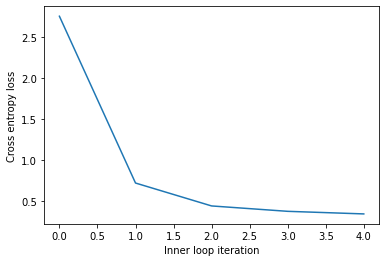

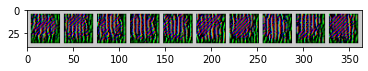

EPOCH: 152 Inner loop losses: 1.033, Train accuracy: 0.109375, Validation accuracy: 0.08984375
EPOCH 152 Final test accuracy: 0.1107421875


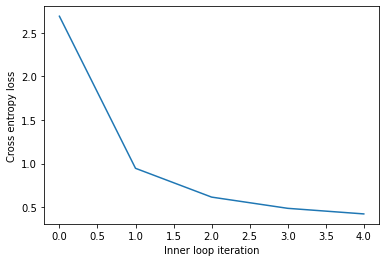

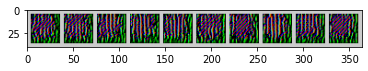

EPOCH: 153 Inner loop losses: 1.097, Train accuracy: 0.08203125, Validation accuracy: 0.1171875
EPOCH 153 Final test accuracy: 0.0955078125


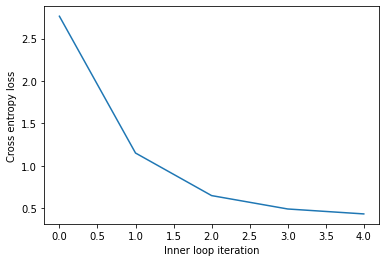

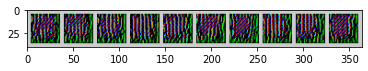

EPOCH: 154 Inner loop losses: 1.042, Train accuracy: 0.109375, Validation accuracy: 0.08984375
EPOCH 154 Final test accuracy: 0.11240234375


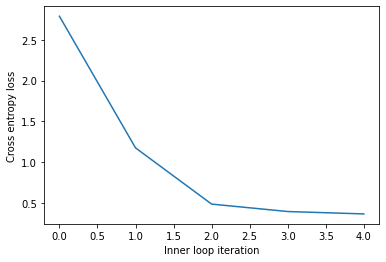

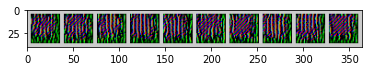

EPOCH: 155 Inner loop losses: 1.006, Train accuracy: 0.10546875, Validation accuracy: 0.09375
EPOCH 155 Final test accuracy: 0.1005859375


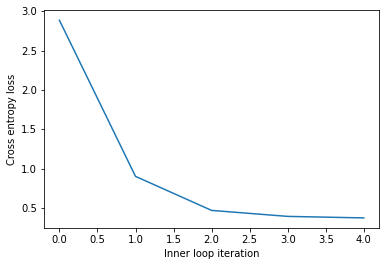

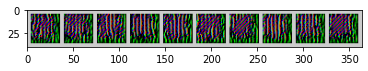

EPOCH: 156 Inner loop losses: 0.749, Train accuracy: 0.08203125, Validation accuracy: 0.0703125
EPOCH 156 Final test accuracy: 0.10400390625


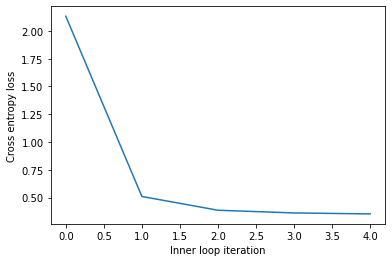

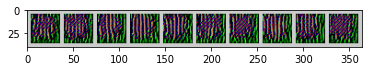

EPOCH: 157 Inner loop losses: 0.811, Train accuracy: 0.10546875, Validation accuracy: 0.078125
EPOCH 157 Final test accuracy: 0.10380859375


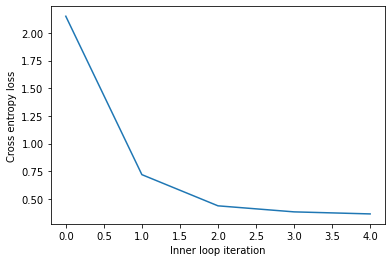

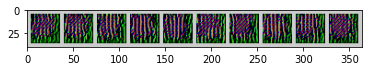

EPOCH: 158 Inner loop losses: 1.075, Train accuracy: 0.1015625, Validation accuracy: 0.05859375
EPOCH 158 Final test accuracy: 0.0849609375


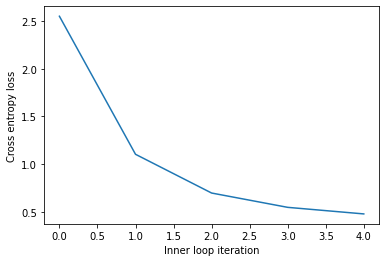

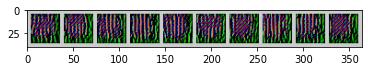

EPOCH: 159 Inner loop losses: 1.239, Train accuracy: 0.11328125, Validation accuracy: 0.0859375
EPOCH 159 Final test accuracy: 0.112109375


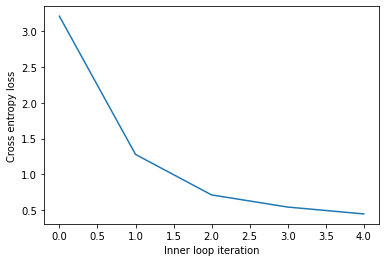

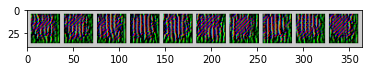

EPOCH: 160 Inner loop losses: 1.292, Train accuracy: 0.08984375, Validation accuracy: 0.09765625
EPOCH 160 Final test accuracy: 0.09423828125


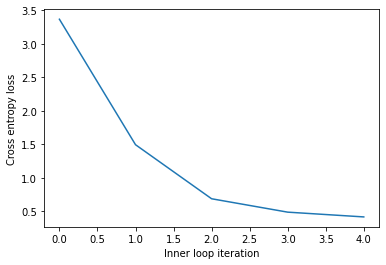

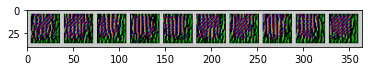

EPOCH: 161 Inner loop losses: 1.123, Train accuracy: 0.07421875, Validation accuracy: 0.07421875
EPOCH 161 Final test accuracy: 0.096875


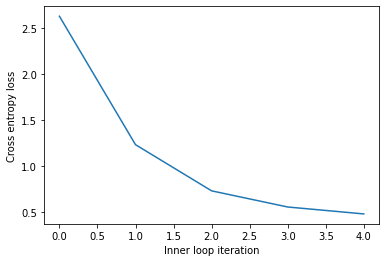

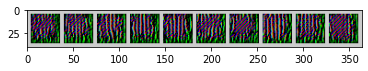

EPOCH: 162 Inner loop losses: 1.015, Train accuracy: 0.11328125, Validation accuracy: 0.10546875
EPOCH 162 Final test accuracy: 0.1076171875


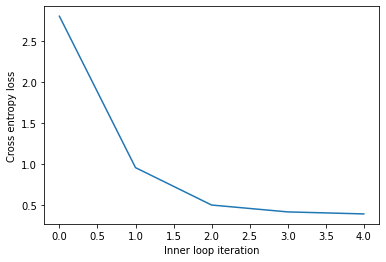

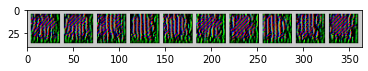

EPOCH: 163 Inner loop losses: 0.805, Train accuracy: 0.09765625, Validation accuracy: 0.07421875
EPOCH 163 Final test accuracy: 0.09794921875


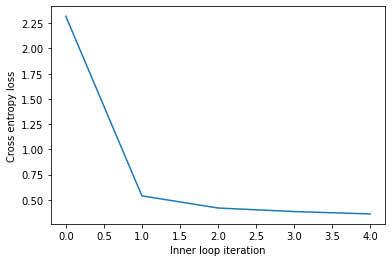

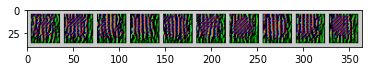

EPOCH: 164 Inner loop losses: 1.017, Train accuracy: 0.08984375, Validation accuracy: 0.1015625
EPOCH 164 Final test accuracy: 0.101953125


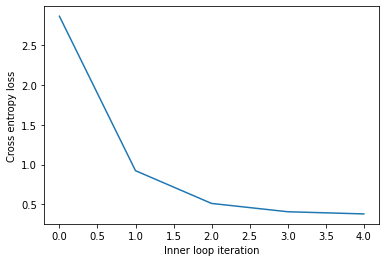

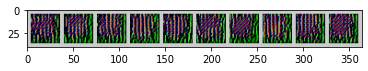

EPOCH: 165 Inner loop losses: 0.835, Train accuracy: 0.0859375, Validation accuracy: 0.07421875
EPOCH 165 Final test accuracy: 0.09560546875


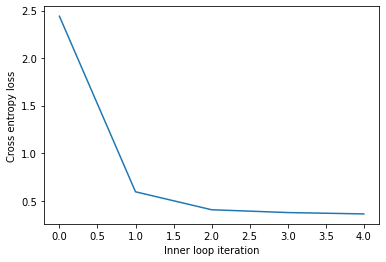

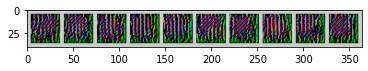

EPOCH: 166 Inner loop losses: 0.864, Train accuracy: 0.0859375, Validation accuracy: 0.08203125
EPOCH 166 Final test accuracy: 0.09931640625


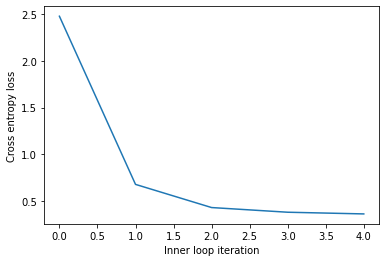

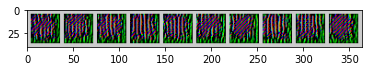

EPOCH: 167 Inner loop losses: 0.923, Train accuracy: 0.10546875, Validation accuracy: 0.1015625
EPOCH 167 Final test accuracy: 0.1185546875


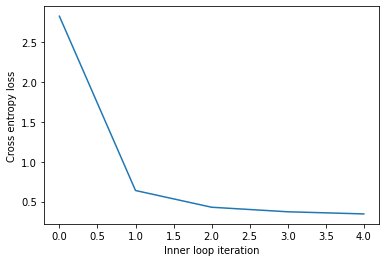

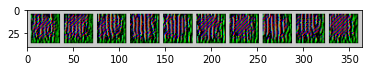

EPOCH: 168 Inner loop losses: 0.997, Train accuracy: 0.15234375, Validation accuracy: 0.0703125
EPOCH 168 Final test accuracy: 0.10888671875


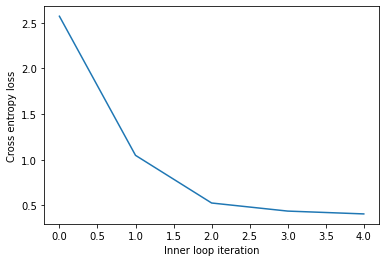

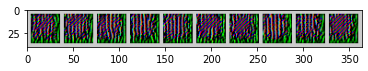

EPOCH: 169 Inner loop losses: 0.839, Train accuracy: 0.1171875, Validation accuracy: 0.10546875
EPOCH 169 Final test accuracy: 0.105078125


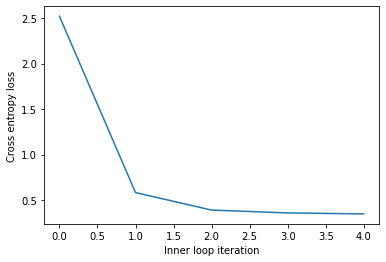

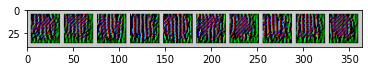

EPOCH: 170 Inner loop losses: 0.993, Train accuracy: 0.06640625, Validation accuracy: 0.1171875
EPOCH 170 Final test accuracy: 0.09443359375


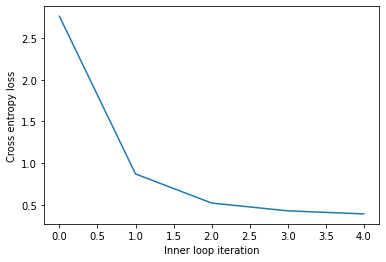

RuntimeError: ignored

In [78]:
for it, (real_data, real_target) in enumerate(tqdm(train)):
    real_data = real_data.to(device)
    real_target = real_target.to(device)
    gen.train()
    opt.zero_grad()
    learner_lr = lr
    learner_momentum_eps = momentum_eps

    learner = Learner().to(device)
    learner_opt = torch.optim.SGD(learner.parameters(), lr=learner_lr, momentum=learner_momentum_eps)
    learner.train()
    inner_losses = []
    for step in range(inner_loop_epoch):
        z = torch.randn(outer_loop_batch_size, noise_size).to(device)
        one_hot = nn.functional.one_hot(real_target, number_classes).to(device)
        gen_pred, teacher_target = gen(z, one_hot)

        if step == inner_loop_epoch - 1:
            output_image_display(gen_pred, teacher_target)

        learner_pred = learner(gen_pred)
        loss = criterion(learner_pred, torch.argmax(one_hot, 1))
        loss.backward()
        learner_opt.step()
        inner_losses.append(loss.cpu().detach().numpy())
    correct = 0
    learner_output = learner(real_data)
    loss_gen = criterion(learner_output, real_target)
    pred = learner_output.argmax(dim=1, keepdim=True)
    correct += pred.eq(real_target.view_as(pred)).sum().item()
    accuracy_train = correct / real_target.shape[0]

    # Evaluate on Dev set
    dev_data, dev_target = next(iter(dev))
    dev_data, dev_target = dev_data.to(device), dev_target.to(device)
    dev_output = learner(dev_data)
    dev_pred = dev_output.argmax(dim=1, keepdim=True)
    correct = pred.eq(dev_target.view_as(pred)).sum().item()
    accuracy_dev = correct / outer_loop_batch_size
    print(f"EPOCH: {it} Inner loop losses: {round(sum(inner_losses) / inner_losses.__len__(), 3)}, "
          f"Train accuracy: {accuracy_train}, "
          f"Validation accuracy: {accuracy_dev}")
    # Evaluate on Test set
    if (it % test_eval_step == 0):
        # Compute accuracy on test set
        correct = 0
        for i, (data, target) in enumerate(test):
            data, target = data.to(device), target.to(device)
            output = learner(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / (outer_loop_batch_size * len(test))
        print(f"EPOCH {it} Final test accuracy:", accuracy)

        # Final inner loop training curve
        # plt.plot(np.arange(len(inner_losses)), inner_losses)
        plt.plot(inner_losses)
        plt.xlabel("Inner loop iteration")
        plt.ylabel("Cross entropy loss")
        plt.show()
    loss_gen.backward()
    opt.step()


**first import higher**

In [70]:
if 'higher' not in sys.modules:
    !pip install higher
import higher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
for it, (real_data, real_target) in enumerate(tqdm(train)):
    real_data, real_target = real_data.to(device), real_target.to(device)
    gen.train()
    opt.zero_grad()
    learner_lr = lr
    learner_momentum_eps = momentum_eps

    learner = Learner().to(device)
    learner_opt = torch.optim.SGD(learner.parameters(), lr=learner_lr, momentum=learner_momentum_eps)
    learner.train()
    inner_losses = []
    with higher.innerloop_ctx(learner, learner_opt, override={'lr': [learner_lr], 'momentum': [learner_momentum_eps]}) as (flearner, diffopt):
        for step in range(inner_loop_epoch):
            if use_curriculum:
                z = curriculum[step]
            else:
                z = torch.randn(outer_loop_batch_size, noise_size)
            one_hot = nn.functional.one_hot(real_target, number_classes)
            gen_pred, teacher_target = gen(z, one_hot)

            if step == inner_loop_epoch - 1:
                output_image_display(gen_pred, teacher_target)

            learner_pred = flearner(gen_pred)
            loss = criterion(learner_pred, torch.argmax(one_hot, 1))
            diffopt.step(loss)
            inner_losses.append(loss.detach().numpy().item())
        correct = 0
        learner_output = flearner(real_data)
        loss_gen = criterion(learner_output, real_target)
        pred = learner_output.argmax(dim=1, keepdim=True)
        correct += pred.eq(real_target.view_as(pred)).sum().item()
        accuracy_train = correct / real_target.shape[0]

        # Evaluate on Dev set
        dev_data, dev_target = next(iter(dev))
        dev_data, dev_target = dev_data.to(device), dev_target.to(device)
        dev_output = flearner(dev_data)
        dev_pred = dev_output.argmax(dim=1, keepdim=True)
        correct = pred.eq(dev_target.view_as(pred)).sum().item()
        accuracy_dev = correct / outer_loop_batch_size
        print(f"EPOCH: {it} Inner loop losses: {round(sum(inner_losses) / inner_losses.__len__(), 3)}, "
              f"Train accuracy: {accuracy_train}, "
              f"Validation accuracy: {accuracy_dev}")
        # Evaluate on Test set
        if (it % test_eval_step == 0):
            # Compute accuracy on test set
            correct = 0
            for i, (data, target) in enumerate(test):
                data, target = data.to(device), target.to(device)
                output = flearner(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / (outer_loop_batch_size * len(test))
            print(f"EPOCH {it} Final test accuracy:", accuracy)

            # Final inner loop training curve
            # plt.plot(np.arange(len(inner_losses)), inner_losses)
            plt.plot(inner_losses)
            plt.xlabel("Inner loop iteration")
            plt.ylabel("Cross entropy loss")
            plt.show()
        loss_gen.backward()
    opt.step()


In [ ]:
num_architectures = 10

best_accuracy = 0

for i in range(num_architectures):

    # Randomly sample architecture
    conv1_filters = np.random.randint(32, 64)
    conv2_filters = np.random.randint(64, 256)
    learner_lr = lr
    learner_momentum_eps = momentum_eps
    learner = Learner(conv1_filters, conv2_filters).to(device)
    inner_optim = torch.optim.SGD(learner.parameters(), lr=learner_lr, momentum=learner_momentum_eps)
    learner.train()

    # For some reason if we don't use higher here, accuracy drops significantly
    with higher.innerloop_ctx(learner, inner_optim,
                              override={'lr': [learner_lr], 'momentum': [learner_momentum_eps]}) as (flearner, diffopt):
        for step in range(inner_loop_epoch):

            # Data generation
            if use_curriculum:
                z_vec = curriculum[step]
            else:
                z_vec = torch.randn(outer_loop_batch_size, noise_size).to(device)

            one_hot = nn.functional.one_hot(label, number_classes).to(device)

            # Pass input to teacher to generate synthetic images
            teacher_output, teacher_target = gen(z_vec, one_hot)

            # Pass teacher output to the learner
            learner_output = flearner(teacher_output)
            loss = criterion(learner_output, label)
            diffopt.step(loss)

        # Compute accuracy on validation set
        correct = 0
        for val_idx, (data, target) in enumerate(dev, 0):
            data, target = data.to(device), target.to(device)
            output = flearner(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / (outer_loop_batch_size * len(dev))

        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            filter_counts = (conv1_filters, conv2_filters)

        print("------------------------- Architecture", i + 1, " -------------------------")
        print("Num conv1 filters:", conv1_filters, ", Num conv2 filters:", conv2_filters, ", Val accuracy:", accuracy)

        if (i == num_architectures - 1):
            correct = 0
            for test_idx, (data, target) in enumerate(test, 0):
                data, target = data.to(device), target.to(device)
                output = flearner(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / (outer_loop_batch_size * len(test))
            print("------------------------- Best architecture -------------------------")
            print("Num conv1 filters:", filter_counts[0], ", Num conv2 filters:", filter_counts[1], ", Test accuracy:",
                  accuracy)
